# Notebook overview

This notebook walks through a defensive, end-to-end pipeline that:

1. Merges primary and secondary book metadata into a single canonical table.
2. Standardizes ISBNs, titles, authors, and genre fields.
3. Limits the merged books to those actually referenced in the ratings dataset.
4. Materializes a hierarchical genre model with root / subgenre lookup tables plus ISBN junction tables.
5. Enriches raw ratings with user and book metadata, producing ready-to-use artifacts.

The workflow prints diagnostics after each major step, expects raw inputs in `../data/interim`, and writes curated outputs to `../data/processed`.

---

**Data dependencies:**

- **Inputs** (expected under `../data/interim`)

| File | Purpose|
|-------|---------|
| `books_cleaned.csv` | Primary book metadata |
| `sec_books_cleaned_imputed.csv` (or `sec_books_cleaned.csv`) | Secondary metadata to enrich gaps |
| `ratings_cleaned.csv` | User–book interactions (implicit + explicit) |
| `users_cleaned_geoloc.csv` | User attributes / geolocation data |

**Outputs** (written to `../data/interim` and `../data/processed`)

| Location | Files produced |
|----------|----------------|
| `../data/interim/` | `books_final.csv`, `book_data.csv`, `root_genres.csv`, `subgenres.csv`, `book_root_genres.csv`, `book_subgenres.csv`, `ratings_enriched.csv` |
| `../data/processed/` | `books.csv` plus any downstream aggregates produced later in the notebook |


---

## Merge strategy overview

1. **Normalize identifiers** – strip punctuation/whitespace from ISBNs, standardize title casing and special characters.
2. **Primary ⬅ Left-join secondary on ISBN** – enrich missing values and keep explicit track of secondary-only columns.
3. **Append secondary-only ISBNs** – increase coverage for books that only exist in the secondary feed.
4. **Title-based fill-ins** – when ISBNs are missing, use normalized titles to backfill critical fields from the secondary table.
5. **Canonicalize columns** – choose final column names, reconcile author lists, and parse genre strings into Python lists.
6. **Ratings filter** – keep only books whose normalized ISBNs appear in the ratings dataset to ensure downstream joinability.

In [4]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import ast
from IPython.display import display


def _compute_relative_target_dir(target_dir: Path) -> str:
    try:
        td = target_dir.resolve()
        # Project root is one level above 'notebooks' directory
        for p in td.parents:
            if (p / "notebooks").exists():
                project_root = p
                break
        rel = "/" + project_root.name + "/" + td.relative_to(project_root).as_posix()
    except Exception:
        rel = target_dir.as_posix()
    return rel

# Create interim directory
interim_dir = Path("../data/interim")
interim_dir.mkdir(parents=True, exist_ok=True)
rel = _compute_relative_target_dir(interim_dir)
print(f"Interim folder: {rel}")

Interim folder: /book_rec_project/data/interim


In [23]:
# Files
BOOKS_MAIN = interim_dir / "books_cleaned.csv"
BOOKS_SEC  = interim_dir / "sec_books_cleaned_imputed.csv"

# Utilities
def normalize_isbn(x):
    # ensure isbn is string type and is a 10 character long, other wise discard:
    if pd.isna(x):
        return np.nan
    s = str(x).strip().upper().replace("-", "").replace(" ", "")
    if len(s) == 10:
        return s
    else:
        # should be 10 chars, else discard
        return np.nan
def normalize_title(x):
    if pd.isna(x):
        return None
    t = str(x).strip().lower()
    t = t.replace("’", "'").replace("–", "-")
    return " ".join(t.split()) or None

def ensure_list(val):
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return []
    if isinstance(val, list):
        return [str(i).strip() for i in val if i is not None and str(i).strip()]
    if isinstance(val, str):
        s = val.strip()
        if not s:
            return []
        try:
            parsed = ast.literal_eval(s)
            if isinstance(parsed, list):
                return [str(i).strip() for i in parsed if i is not None and str(i).strip()]
        except Exception:
            pass
        if "," in s:
            return [p.strip() for p in s.split(",") if p.strip()]
        return [s]
    return [str(val).strip()]

def pick_author_column(df):
    # common candidate names (case-insensitive)
    candidates = ['authors','author','book-author','book_author','book author','book_author(s)','book_author(s)']
    for c in df.columns:
        if any(c.lower() == cand.lower() for cand in candidates) or any(cand in c.lower() for cand in candidates):
            return c
    return None

# Load
if not BOOKS_MAIN.exists():
    raise FileNotFoundError(f"Primary books file not found: {BOOKS_MAIN}")
if not BOOKS_SEC.exists():
    sec_candidates = [interim_dir / "sec_books_cleaned.csv", interim_dir / "sec_books.csv"]
    BOOKS_SEC = next((p for p in sec_candidates if p.exists()), BOOKS_SEC)

df_main = pd.read_csv(BOOKS_MAIN, dtype=str, low_memory=False)
df_sec  = pd.read_csv(BOOKS_SEC,  dtype=str, low_memory=False)

print(f"Loaded books data: Primary with {len(df_main):,} books, Secondary {len(df_sec):,} books.")
# print(f"\nPrimary columns: {df_main.columns.tolist()}")
# print(f"Primary sample data (head):")
# display(df_main.head())
# print("Primary book data columns info:\n")
# display(df_main.info())
# print(f"\nSecondary columns: {df_sec.columns.tolist()}\n")
# print(f"Secondary sample data (head):")
# display(df_sec.head())
# print("Secondary book data columns info:\n")
# display(df_sec.info())

print(f"{'-'*40}\nBeginning merge process...\n{'-'*40}")

# drop stray index cols and strip headers
for df in (df_main, df_sec):
    for c in ("Unnamed: 0","index"):
        if c in df.columns:
            df.drop(columns=[c], inplace=True, errors='ignore')
    df.columns = [c.strip() for c in df.columns]

# Ensure isbn + title columns exist and normalize
def ensure_isbn_col(df):
    if 'isbn' in df.columns:
        return
    cand = next((c for c in df.columns if 'isbn' in c.lower()), None)
    df['isbn'] = df[cand] if cand else pd.NA
   
def ensure_title_col(df):
    if 'title' in df.columns:
        return
    cand = next((c for c in df.columns if 'title' == c.lower() or 'title' in c.lower()), None)
    if cand:
        df['title'] = df[cand]

ensure_isbn_col(df_main); ensure_isbn_col(df_sec)
ensure_title_col(df_main); ensure_title_col(df_sec)

df_main['isbn'] = df_main['isbn'].apply(normalize_isbn)
df_sec['isbn']  = df_sec['isbn'].apply(normalize_isbn)
if 'title' in df_main.columns:
    df_main['title_norm'] = df_main['title'].apply(normalize_title)
if 'title' in df_sec.columns:
    df_sec['title_norm']  = df_sec['title'].apply(normalize_title)

# Robust authors -> authors_list on each source (same column name to make merge deterministic)
for df, name in ((df_main, "main"), (df_sec, "sec")):
    cand = pick_author_column(df)
    raw_col = cand if cand else None
    if raw_col:
        df['authors_raw'] = df[raw_col]
    else:
        # attempt a few common missings: try 'contributors' etc.
        fallback = next((c for c in df.columns if 'author' in c.lower() or 'contributor' in c.lower()), None)
        df['authors_raw'] = df[fallback] if fallback else pd.NA
    df['authors_list'] = df['authors_raw'].apply(ensure_list)

# Merge primary (authoritative) with secondary to enrich missing fields
merged = df_main.copy()
if not df_sec.empty:
    sec_subset = df_sec.copy()
    # keep authors_list on secondary so it will become authors_list_sec after merge
    merge_on = 'isbn' if 'isbn' in merged.columns else ('title_norm' if 'title_norm' in merged.columns and 'title_norm' in sec_subset.columns else None)
    if merge_on:
        merged = merged.merge(sec_subset, on=merge_on, how='left', suffixes=('','_sec'))
    else:
        merged = pd.concat([merged, sec_subset], ignore_index=True, sort=False)

    # --- NEW: robustly preserve secondary-only columns and fill primary from secondary ---
    # list of specific columns you care about (kept for clarity) but logic below is generic
    sec_preserve = ['description','price_usd','price_is_synthetic','genre','image_alternative','previewlink','infolink']
    # compute sec-only columns (excluding keys/helpers)
    excluded = {'isbn','title','title_norm','authors_raw','authors_list'}
    sec_only_cols = [c for c in df_sec.columns if c not in df_main.columns and c not in excluded]

    # union of explicit preserve + any sec-only discovered
    to_ensure = list(dict.fromkeys(sec_preserve + sec_only_cols))

    for c in to_ensure:
        sec_col = f"{c}_sec"
        # If primary column exists, prefer main and fillna from secondary _sec
        if c in merged.columns and sec_col in merged.columns:
            merged[c] = merged[c].combine_first(merged[sec_col])
            merged.drop(columns=[sec_col], inplace=True, errors='ignore')
        # If primary column does not exist but secondary provided it (as suffixed col), bring it in
        elif sec_col in merged.columns and c not in merged.columns:
            merged[c] = merged[sec_col]
            merged.drop(columns=[sec_col], inplace=True, errors='ignore')
        # If secondary column exists without suffix (rare cases), ensure it's present
        elif c in merged.columns and sec_col not in merged.columns:
            # nothing to do: primary already has column
            pass

cols_before = merged.columns.tolist()
print(f"Post-merge columns ({len(merged.columns)} total): {cols_before}")

# After merge: unify fields preferring primary values, else fill from secondary
if not df_sec.empty:
    # iterate secondary columns and only treat suffixed helper cols as removable;
    # do NOT drop a column that originates only from secondary and has no '_sec' suffix.
    for c in df_sec.columns:
        if c in ('isbn','title','title_norm','authors_raw','authors_list'):
            continue

        # If this field existed in primary, pandas produced a '{c}_sec' helper column after merge.
        # Prefer primary and fillna from the helper, then drop the helper.
        if c in df_main.columns:
            sec_col = f"{c}_sec"
            if sec_col in merged.columns:
                # prefer primary values, fill from secondary helper
                merged[c] = merged[c].combine_first(merged[sec_col])
                merged.drop(columns=[sec_col], inplace=True, errors='ignore')
            # if primary had the column but helper is missing (unlikely), leave primary as-is

        else:
            # Column did NOT exist in primary -> it may appear in merged either as:
            #  - 'c' (if pandas didn't create a _sec because no name conflict), or
            #  - 'c_sec' (if name conflict handling created a helper). In either case,
            # bring it into the final merged frame but do NOT drop the actual data column.
            sec_col = f"{c}_sec"
            if c in merged.columns:
                # already present (secondary-only column), keep it as-is
                continue
            elif sec_col in merged.columns:
                # transfer from helper then drop the helper
                merged[c] = merged[sec_col]
                merged.drop(columns=[sec_col], inplace=True, errors='ignore')

cols_after = merged.columns.tolist()
new_cols = [c for c in cols_after if c not in cols_before]
print(f"New columns added from secondary or preserved: {new_cols}")
removed_cols = [c for c in cols_before if c not in cols_after]
print(f"Columns removed after merge: {removed_cols}")

# # debug to check if sec_preserve columns are present
# print("Post-merge columns (checking preserved secondary columns):")
# for c in sec_preserve:
#     if c in merged.columns:
#         n_nonnull = merged[c].notna().sum()
#         print(f" - {c}: present, non-null count = {n_nonnull:,}")
#     else:
#         print(f" - {c}: NOT present in merged data")

# Handle authors: merged may have authors_list (from main) and authors_list_sec (from sec)
main_auth_col = 'authors_list'
sec_auth_col  = 'authors_list_sec' if 'authors_list_sec' in merged.columns else ('authors_list' if 'authors_list' in merged.columns and 'authors_list_sec' not in merged.columns and 'authors_raw_sec' in merged.columns else None)

# If secondary authors list ended up as 'authors_list' (no suffix) because main lacked it, try to rename safely
if 'authors_list' in merged.columns and 'authors_list_sec' not in merged.columns and 'authors_raw_sec' in merged.columns:
    # move the sec authors into authors_list_sec so combine is consistent
    merged['authors_list_sec'] = merged['authors_list']
    merged['authors_list'] = merged.get('authors_list_x', merged.get('authors_list', []))

# Ensure both columns exist as lists
if main_auth_col not in merged.columns:
    merged[main_auth_col] = [[] for _ in range(len(merged))]
if sec_auth_col is None or sec_auth_col not in merged.columns:
    merged['authors_list_sec'] = [[] for _ in range(len(merged))]
    sec_auth_col = 'authors_list_sec'

def combine_author_lists(a, b):
    a = a if isinstance(a, (list,tuple)) else ensure_list(a)
    b = b if isinstance(b, (list,tuple)) else ensure_list(b)
    out = []
    for x in (a + b):
        if x is None:
            continue
        s = str(x).strip()
        if s and s not in out:
            out.append(s)
    return out if out else pd.NA

merged['authors_final'] = merged.apply(lambda r: combine_author_lists(r.get(main_auth_col, []), r.get(sec_auth_col, [])), axis=1)

# Just inspect the distribution of num of authors per book, with counts and percentage:
merged['num_authors_final'] = merged['authors_final'].apply(lambda x: len(x) if isinstance(x, (list,tuple)) else 0)
author_counts = merged['num_authors_final'].value_counts().sort_index()
n_total = len(merged)
print("Distribution of number of authors per book (authors_final):")
for num_auth, count in author_counts.items():
    pct = count / max(1, n_total) * 100
    print(f" - {num_auth} authors: {count:,} books ({pct:.2f}%)")
merged.drop(columns=['num_authors_final'], inplace=True, errors='ignore')


# Drop helper cols but keep original raw author if needed
for c in ('authors_raw','authors_raw_sec','authors_list','authors_list_sec'):
    if c in merged.columns:
        # keep authors_raw from primary as authors_raw_main if present
        if c == 'authors_raw' and 'authors_raw' in merged.columns:
            merged = merged.rename(columns={'authors_raw': 'authors_raw_main'})
            continue
        merged.drop(columns=[c], inplace=True, errors='ignore')

# Debug counts
n_rows = len(merged)
n_auth_nonnull = merged['authors_final'].notna().sum()
print(f"Merged rows: {n_rows:,}; rows with authors_final: {n_auth_nonnull:,} ({n_auth_nonnull/max(1,n_rows):.1%})")
print("Sample authors_final (non-null) head:")
display(merged[merged['authors_final'].notna()][['isbn','title','authors_final']].head(12))

# Final normalize title_norm if present
if 'title' in merged.columns:
    merged['title_norm'] = merged['title'].apply(normalize_title)

columns_required = ['title','isbn', 'authors_final', 'publisher', 'publication_year']

# Distribution of missing data in the required columns:
print("Missing values in required columns before dropping incomplete rows:")
for col in columns_required:
    if col in merged.columns:
        n_missing = merged[col].isna().sum()
        print(f" - {col}: {n_missing:,} missing ({n_missing/max(1,n_rows):.1%})")
    else:
        print(f" - {col}: column not present in merged data")

# drop books where any of required columns has a missing value:
# and also drop rows with duplicated isbn (if isbn present):
num_books_before = len(merged)
for col in columns_required:
    if col in merged.columns:
        if col == 'isbn' :
            # keep first occurrence of each isbn, drop duplicates
            merged = merged[~merged.duplicated(subset=[col], keep='first')]
        merged = merged[merged[col].notna()]

num_books_after = len(merged)
print(f"Dropped {num_books_before - num_books_after:,} rows ({(num_books_before - num_books_after)/num_books_before:.1%} of initial count) due to missing required columns or duplicate ISBNs.")
merged = merged.reset_index(drop=True)


# ---------------- persist result (preview + debug before commit) ----------------

# Diagnostic / preview cell - run this to inspect merged dataframe, compute
# how many values came from secondary, and decide rename/drop/reorder before saving.

preview_rows = 8            # rows to show in head/tail previews
show_top_n = 20             # how many top values to show for categorical cols
commit_save = True         # set True to write the file after making rename/drop/reorder changes

# Optional edits you can set interactively and re-run cell:
drop_cols = ['author', 'title_norm', 'authors_raw_main', 'title_sec', 'authors', 'title_norm_sec',]              # e.g. ['unwanted_col1', 'temp_col2']
rename_map = {'authors_final': 'authors'}             
column_order = ['isbn', 'title', 'authors', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l', 'description', 'price_usd', 'price_is_synthetic', 'genre', 'image_alternative', 'previewlink', 'infolink']
out_path = interim_dir / "books_merged.csv"
rel_out = _compute_relative_target_dir(out_path)

print("=== MERGE PREVIEW & DIAGNOSTICS ===")
print(f"Rows: {len(merged):,} | Columns: {len(merged.columns)}\n")

# Basic previews
print(">>> HEAD")
display(merged.head(preview_rows))
print("\n>>> TAIL")
display(merged.tail(preview_rows))

# dtypes and non-null counts
print("\n>>> DTYPE / NON-NULL COUNTS")
info_buf = []
display(merged.info())

# Missing values summary
miss = merged.isna().sum().sort_values(ascending=False)
miss_pct = (miss / max(1, len(merged)) * 100).round(2)
miss_df = pd.DataFrame({"missing_count": miss, "missing_pct": miss_pct})
print("\n>>> MISSING VALUES Counts and Percentages:")
display(miss_df[miss_df['missing_count'] > 0])

# Basic uniqueness / duplicates checks
if 'isbn' in merged.columns:
    n_unique_isbn = merged['isbn'].nunique(dropna=True)
    n_nan_isbn = merged['isbn'].isna().sum()
    n_dup_isbn = merged.duplicated(subset=['isbn']).sum()
    print(f"\nISBN: unique={n_unique_isbn:,}, NaN={n_nan_isbn:,}, duplicated_rows={n_dup_isbn:,}")
else:
    print("\nNo 'isbn' column present in merged frame.")

# Top value summaries for key columns (if present)
top_cols = ['title','author','authors_join','publisher','genre','publication_year']
print("\n>>> TOP VALUE COUNTS (sample columns)")
for c in top_cols:
    if c in merged.columns:
        print(f"\n-- {c} (top {show_top_n})")
        display(merged[c].value_counts(dropna=True).head(show_top_n))

# How many rows are "new" because secondary provided a value where main missed?
# This requires original df_main / df_sec to be available (they are earlier in the notebook).
fill_stats = []
if 'df_main' in globals():
    # ensure we create an index with unique keys (Series.map requires a unique index)
    if not df_main.empty and 'isbn' in df_main.columns:
        df_main_idx = df_main.set_index('isbn')
        if not df_main_idx.index.is_unique:
            # keep the first occurrence per ISBN to make index unique
            df_main_idx = df_main_idx.groupby(level=0).first()
    else:
        df_main_idx = None
else:
    df_main_idx = None
if 'df_sec' in globals():
    if not df_sec.empty and 'isbn' in df_sec.columns:
        df_sec_idx = df_sec.set_index('isbn')
        if not df_sec_idx.index.is_unique:
            # if secondary contains duplicates by ISBN, reduce to first per ISBN
            df_sec_idx = df_sec_idx.groupby(level=0).first()
    else:
        df_sec_idx = None
else:
    df_sec_idx = None

# Columns to examine: intersection/union of main/sec/merged (excluding isbn/title_norm helper)
candidates = [c for c in merged.columns if c not in ('isbn','title_norm')]
# limit to reasonable number to avoid noise
candidates = sorted(candidates)[:120]

for c in candidates:
    # Skip helper columns we created earlier
    if c.endswith('_sec'):
        continue
    # Prepare mapped series from main/sec for this column (if available)
    main_map = None
    sec_map = None
    if df_main_idx is not None and c in df_main_idx.columns:
        main_map = merged['isbn'].map(df_main_idx[c])
    if df_sec_idx is not None and c in df_sec_idx.columns:
        sec_map = merged['isbn'].map(df_sec_idx[c])

    # Compute stats only if we have at least one reference map and the merged column exists
    if (main_map is None and sec_map is None) or c not in merged.columns:
        continue

    merged_val = merged[c]
    # Rows where main lacked a value, merged has a value, and secondary had a value (i.e. filled-from-secondary)
    filled_mask = pd.Series(False, index=merged.index)
    if main_map is not None and sec_map is not None:
        filled_mask = main_map.isna() & merged_val.notna() & sec_map.notna()
    elif main_map is not None and sec_map is None:
        # If no secondary column originally, we cannot count fills-from-sec
        filled_mask = pd.Series(False, index=merged.index)
    elif main_map is None and sec_map is not None:
        # Main had no column; many merged values come from secondary
        filled_mask = merged_val.notna() & sec_map.notna()

    n_filled = int(filled_mask.sum())
    n_main_missing = int((main_map.isna().sum() if main_map is not None else 0))
    pct_of_main_missing = (n_filled / max(1, n_main_missing) * 100) if n_main_missing > 0 else None

    fill_stats.append({
        "column": c,
        "filled_from_secondary": n_filled,
        "main_missing_count": n_main_missing,
        "pct_of_main_missing_filled": round(pct_of_main_missing,2) if pct_of_main_missing is not None else None
    })

fill_stats_df = pd.DataFrame(fill_stats).sort_values(by='filled_from_secondary', ascending=False).reset_index(drop=True)
print("\n>>> FILL-ORIGIN STATISTICS (how many values appear to have been filled from secondary)")
display(fill_stats_df.head(40))

# Duplicates by other keys (author+title)
if all(x in merged.columns for x in ('title','author')):
    dup_ta = merged.duplicated(subset=['title','author'], keep=False).sum()
    print(f"\nRows duplicated by (title,author) pair: {dup_ta:,}")

# Allow user to preview rename/drop/reorder
print("\n>>> Preview renaming / dropping / reordering (no file write unless commit_save=True)")
print("Rename map:", rename_map)
print("Drop columns list:", drop_cols)
print("Target column order:", "None" if column_order is None else column_order)

preview_df = merged.copy()
# drop columns
if drop_cols:
    preview_df = preview_df.drop(columns=[c for c in drop_cols if c in preview_df.columns], errors='ignore')
# apply rename preview
if rename_map:
    preview_df = preview_df.rename(columns=rename_map)
# reorder if requested
if column_order:
    # keep any columns not included in requested order appended at the end
    remaining = [c for c in preview_df.columns if c not in column_order]
    new_order = [c for c in column_order if c in preview_df.columns] + remaining
    preview_df = preview_df[new_order]

print("\n>>> Previewed schema and head after modifications")
print(f"Rows: {len(preview_df):,} | Columns: {len(preview_df.columns)}")
print(f"Columns and current order: {preview_df.columns.tolist()}\n")
display(preview_df.head(preview_rows))
rel = _compute_relative_target_dir(interim_dir)
print(f"Interim folder: {rel}")
print("\nIf satisfied, set commit_save = True and re-run this cell to persist to:", rel_out)

# Commit/save if requested
if commit_save:
    try:
        preview_df.to_csv(out_path, index=False, encoding='utf-8')
        print(f"\nSaved merged books data to {rel_out} ({len(preview_df):,} rows)")
    except Exception as e:
        print(f"\nError saving file: {e}")
else:
    print("\ncommit_save is False -> no file changes written. Make edits then set commit_save=True to save.")

Loaded books data: Primary with 271,360 books, Secondary 212,404 books.
----------------------------------------
Beginning merge process...
----------------------------------------
Post-merge columns (25 total): ['isbn', 'title', 'author', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l', 'title_norm', 'authors_raw', 'authors_list', 'title_sec', 'authors', 'publication_year_sec', 'publisher_sec', 'description', 'price_usd', 'price_is_synthetic', 'genre', 'image_alternative', 'previewlink', 'infolink', 'title_norm_sec', 'authors_raw_sec', 'authors_list_sec']
New columns added from secondary or preserved: []
Columns removed after merge: ['publication_year_sec', 'publisher_sec']
Distribution of number of authors per book (authors_final):
 - 0 authors: 2 books (0.00%)
 - 1 authors: 267,735 books (86.71%)
 - 2 authors: 35,162 books (11.39%)
 - 3 authors: 4,504 books (1.46%)
 - 4 authors: 1,013 books (0.33%)
 - 5 authors: 210 books (0.07%)
 - 6 authors: 86 books (

,isbn,title,authors_final
0,0195153448,Classical Mythology,[Mark P. O. Morford]
1,0002005018,Clara Callan,[Richard Bruce Wright]
2,0060973129,Decision in Normandy,[Carlo D'Este]
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,[Gina Bari Kolata]
4,0393045218,The Mummies of Urumchi,[E. J. W. Barber]
5,0399135782,The Kitchen God's Wife,[Amy Tan]
6,0425176428,What If?: The World's Foremost Military Histor...,[Robert Cowley]
7,0671870432,PLEADING GUILTY,[Scott Turow]
8,0679425608,Under the Black Flag: The Romance and the Real...,[David Cordingly]
9,074322678X,Where You'll Find Me: And Other Stories,[Ann Beattie]


Missing values in required columns before dropping incomplete rows:
 - title: 0 missing (0.0%)
 - isbn: 37,431 missing (12.1%)
 - authors_final: 2 missing (0.0%)
 - publisher: 2 missing (0.0%)
 - publication_year: 4,588 missing (1.5%)
Dropped 42,331 rows (13.7% of initial count) due to missing required columns or duplicate ISBNs.
=== MERGE PREVIEW & DIAGNOSTICS ===
Rows: 266,457 | Columns: 21

>>> HEAD


,isbn,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l,title_norm,authors_raw_main,...,authors,description,price_usd,price_is_synthetic,genre,image_alternative,previewlink,infolink,title_norm_sec,authors_final
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,classical mythology,Mark P. O. Morford,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Mark P. O. Morford]
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,clara callan,Richard Bruce Wright,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Richard Bruce Wright]
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,decision in normandy,Carlo D'Este,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Carlo D'Este]
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,flu: the story of the great influenza pandemic...,Gina Bari Kolata,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Gina Bari Kolata]
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,the mummies of urumchi,E. J. W. Barber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[E. J. W. Barber]
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,the kitchen god's wife,Amy Tan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Amy Tan]
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,what if?: the world's foremost military histor...,Robert Cowley,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Robert Cowley]
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,pleading guilty,Scott Turow,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Scott Turow]



>>> TAIL


,isbn,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l,title_norm,authors_raw_main,...,authors,description,price_usd,price_is_synthetic,genre,image_alternative,previewlink,infolink,title_norm_sec,authors_final
266449,1845170423,Cocktail Classics,David Biggs,2004,Connaught,http://images.amazon.com/images/P/1845170423.0...,http://images.amazon.com/images/P/1845170423.0...,http://images.amazon.com/images/P/1845170423.0...,cocktail classics,David Biggs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[David Biggs]
266450,014002803X,Anti Death League,Kingsley Amis,1975,Viking Press,http://images.amazon.com/images/P/014002803X.0...,http://images.amazon.com/images/P/014002803X.0...,http://images.amazon.com/images/P/014002803X.0...,anti death league,Kingsley Amis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Kingsley Amis]
266451,0449906736,Flashpoints: Promise and Peril in a New World,Robin Wright,1993,Ballantine Books,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...,flashpoints: promise and peril in a new world,Robin Wright,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Robin Wright]
266452,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,there's a bat in bunk five,Paula Danziger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Paula Danziger]
266453,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,from one to one hundred,Teri Sloat,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Teri Sloat]
266454,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,lily dale : the true story of the town that ta...,Christine Wicker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Christine Wicker]
266455,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,republic (world's classics),Plato,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Plato]
266456,0767409752,A Guided Tour of Rene Descartes' Meditations o...,Christopher Biffle,2000,McGraw-Hill Humanities/Social Sciences/Languages,http://images.amazon.com/images/P/0767409752.0...,http://images.amazon.com/images/P/0767409752.0...,http://images.amazon.com/images/P/0767409752.0...,a guided tour of rene descartes' meditations o...,Christopher Biffle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Christopher Biffle]



>>> DTYPE / NON-NULL COUNTS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266457 entries, 0 to 266456
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   isbn                266457 non-null  object
 1   title               266457 non-null  object
 2   author              266457 non-null  object
 3   publication_year    266457 non-null  object
 4   publisher           266457 non-null  object
 5   image_url_s         266457 non-null  object
 6   image_url_m         266457 non-null  object
 7   image_url_l         266457 non-null  object
 8   title_norm          266457 non-null  object
 9   authors_raw_main    266457 non-null  object
 10  title_sec           16152 non-null   object
 11  authors             14068 non-null   object
 12  description         12701 non-null   object
 13  price_usd           16152 non-null   object
 14  price_is_synthetic  16152 non-null   object
 15  genre               13

None


>>> MISSING VALUES Counts and Percentages:


,missing_count,missing_pct
description,253756,95.23
image_alternative,253481,95.13
genre,252919,94.92
authors,252389,94.72
previewlink,252064,94.60
infolink,252064,94.60
title_norm_sec,250305,93.94
title_sec,250305,93.94
price_usd,250305,93.94
price_is_synthetic,250305,93.94



ISBN: unique=266,457, NaN=0, duplicated_rows=0

>>> TOP VALUE COUNTS (sample columns)

-- title (top 20)


title
Selected Poems                    27
Little Women                      22
Dracula                           20
Wuthering Heights                 20
Adventures of Huckleberry Finn    20
The Secret Garden                 18
The Night Before Christmas        18
Pride and Prejudice               17
Jane Eyre                         16
Black Beauty                      16
Masquerade                        16
The Gift                          15
Great Expectations                15
Beloved                           14
Frankenstein                      14
The Wedding                       13
The Secret                        13
Illusions                         13
Nemesis                           13
Fahrenheit 451                    13
Name: count, dtype: int64


-- author (top 20)


author
Agatha Christie          597
William Shakespeare      558
Stephen King             509
Ann M. Martin            423
Francine Pascal          371
Carolyn Keene            371
Isaac Asimov             328
Nora Roberts             311
Barbara Cartland         307
Charles Dickens          295
Not Applicable (Na )     286
R. L. Stine              279
Mark Twain               225
Terry Pratchett          217
Piers Anthony            216
Mary Higgins Clark       215
Marion Zimmer Bradley    213
Janet Dailey             212
Jane Austen              209
Franklin W. Dixon        204
Name: count, dtype: int64


-- publisher (top 20)


publisher
Harlequin                   7532
Silhouette                  4218
Pocket                      3861
Ballantine Books            3753
Bantam Books                3636
Scholastic                  3149
Simon &amp; Schuster        2959
Penguin Books               2835
Berkley Publishing Group    2756
Penguin USA                 2711
Warner Books                2696
Harpercollins               2517
Fawcett Books               2255
Signet Book                 2067
Random House Inc            2040
St Martins Pr               1951
St. Martin's Press          1778
Tor Books                   1703
Zebra Books                 1694
HarperCollins Publishers    1688
Name: count, dtype: int64


-- genre (top 20)


genre
['Fiction']                      4395
['Juvenile Fiction']              917
['Biography & Autobiography']     501
['Religion']                      494
['History']                       392
['Body, Mind & Spirit']           280
['Social Science']                255
['Business & Economics']          244
['Family & Relationships']        225
['Juvenile Nonfiction']           218
['Cooking']                       208
['Health & Fitness']              202
['Computers']                     194
['Humor']                         184
['Self-Help']                     178
['Travel']                        153
['Comics & Graphic Novels']       147
['Literary Criticism']            135
['Psychology']                    123
['Poetry']                        121
Name: count, dtype: int64


-- publication_year (top 20)


publication_year
2002    17614
1999    17411
2001    17338
2000    17211
1998    15752
1997    14874
2003    14332
1996    14014
1995    13525
1994    11779
1993    10594
1992     9888
1991     9380
1990     8652
1989     7927
1988     7487
1987     6523
1986     5836
2004     5834
1985     5338
Name: count, dtype: int64


>>> FILL-ORIGIN STATISTICS (how many values appear to have been filled from secondary)


,column,filled_from_secondary,main_missing_count,pct_of_main_missing_filled
0,price_is_synthetic,16152,0,NaN
1,price_usd,16152,0,NaN
2,previewlink,14393,0,NaN
3,infolink,14393,0,NaN
4,authors,14068,0,NaN
5,genre,13538,0,NaN
6,image_alternative,12976,0,NaN
7,description,12701,0,NaN
8,publication_year,47,47,100.0
9,author,0,0,NaN



Rows duplicated by (title,author) pair: 34,436

>>> Preview renaming / dropping / reordering (no file write unless commit_save=True)
Rename map: {'authors_final': 'authors'}
Drop columns list: ['author', 'title_norm', 'authors_raw_main', 'title_sec', 'authors', 'title_norm_sec']
Target column order: ['isbn', 'title', 'authors', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l', 'description', 'price_usd', 'price_is_synthetic', 'genre', 'image_alternative', 'previewlink', 'infolink']

>>> Previewed schema and head after modifications
Rows: 266,457 | Columns: 15
Columns and current order: ['isbn', 'title', 'authors', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l', 'description', 'price_usd', 'price_is_synthetic', 'genre', 'image_alternative', 'previewlink', 'infolink']



,isbn,title,authors,publication_year,publisher,image_url_s,image_url_m,image_url_l,description,price_usd,price_is_synthetic,genre,image_alternative,previewlink,infolink
0,0195153448,Classical Mythology,[Mark P. O. Morford],2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0002005018,Clara Callan,[Richard Bruce Wright],2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0060973129,Decision in Normandy,[Carlo D'Este],1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,[Gina Bari Kolata],1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0393045218,The Mummies of Urumchi,[E. J. W. Barber],1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0399135782,The Kitchen God's Wife,[Amy Tan],1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0425176428,What If?: The World's Foremost Military Histor...,[Robert Cowley],2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0671870432,PLEADING GUILTY,[Scott Turow],1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Interim folder: /book_rec_project/data/interim

If satisfied, set commit_save = True and re-run this cell to persist to: /book_rec_project/data/interim/books_merged.csv

Saved merged books data to /book_rec_project/data/interim/books_merged.csv (266,457 rows)



---

## Genre hierarchy materialization

To standardize the extremely noisy genre strings, we load a handcrafted hierarchy and:

1. Persist it as `genre_tree.json` (for reuse / auditing).
2. Parse each book’s raw genre list into normalized tokens.
3. Map tokens to root + subgenre labels via a lookup.
4. Emit supporting tables:
   - `root_genres.csv`, `subgenres.csv`
   - Junction tables `book_root_genres.csv` and `book_subgenres.csv`
5. Export `books_genres.csv`, the book catalog augmented with parsed `root_genres` / `sub_genres`.

Each step prints coverage statistics and highlights unmapped categories for debugging.

In [ ]:
# Hierarchical category system - Created with the help of LLMs
genre_hierarchy = {
    'Fiction': {
        'General Fiction': ['Fiction', 'Fiction in English', 'American fiction', 'English fiction', 
                           'Canadian fiction', 'Australian fiction', 'Irish fiction', 'Scottish fiction',
                           'New Zealand fiction', 'Domestic fiction', 'Domestic fiction, American',
                           'Literary fiction', 'Popular literature', 'Experimental fiction',
                           'Dutch fiction', 'Spanish fiction', 'Argentine fiction', 'Czech fiction',
                           'Indic fiction (English)', 'Italian fiction', 'Japanese fiction',
                           'Botswanan fiction (English)', 'Russian fiction', 'Samoan fiction',
                           'Fiction in English, 1900-1945 - Texts', 'Classical fiction',
                           'Musical fiction', 'Film novelizations', 'Gothic novels',
                           'Amerikaanse fiksie', 'French fiction'],
        
        'Mystery & Crime': ['Detective and mystery stories', 'Detective and mystery stories, American',
                           'Detective and mystery stories, English', 'Detective and mystery stories, New Zealand',
                           'Crime', 'Crime and criminals', 'Mystery & Detective Stories', 'Noir fiction',
                           'Code and cipher stories', 'Detectives', 'Private investigators',
                           'Private investigation', 'Murder', 'Homicide', 'Serial killers',
                           'Criminal psychology', 'Criminal investigation', 'True Crime',
                           'Forensic psychology', 'Criminals', 'Brigands and robbers',
                           'Mafia', 'Organized crime', 'Commercial crimes',
                           # Fictional detectives
                           'Poirot, Hercule (Fictitious character)', 'Marple, Jane (Fictitious character)',
                           'Holmes, Sherlock (Fictitious character)', 'Beck, Martin (Fictitious character)',
                           'Bosch, Harry (Fictitious character)', 'Alleyn, Roderick (Fictitious character)',
                           'Appleby, John, Sir (Fictitious character)', 'Battle, Superintendent (Fictitious character)',
                           'Cadfael, Brother (Fictitious character)', 'Campion, Albert (Fictitious character)',
                           'Balzic, Mario (Fictitious character)', 'Chimera, Hertzan (Fictitious character)',
                           'Ashton, Carol (Fictitious character)'],
        
        'Science Fiction & Fantasy': ['Science fiction', 'Science fiction, American', 'Science fiction, British',
                                     'Science fiction, Australian', 'Science fiction, French', 'Fantasy fiction',
                                     'Fantasy fiction, American', 'Fantasy', 'Dystopian fiction',
                                     'Time travel', 'Interplanetary voyages', 'Life on other planets',
                                     'Extraterrestial beings', 'Human-alien encounters', 'Alien abduction',
                                     'Science fiction.', 'Science fiction, American.', 'Fantasy games',
                                     'Dungeons and Dragons (Game)', 'Dragons', 'Dragons in literature',
                                     'Elves', 'Dwarfs (Persons)', 'Wizards', 'Magic realism (Literature)',
                                     'Unicorns', 'Fairies', 'Fantastic fiction, Cuban', 'Fourth dimension',
                                     'Jupiter (Planet)', 'Moon', 'Rama (Imaginary space vehicle)',
                                     'Discworld (Imaginary place)', 'Amber (Imaginary place)',
                                     'Genetic engineering', 'Robots', 'Future life',
                                     # Fantasy elements
                                     'Goddesses', 'Gods, Chinese', 'Grail', 'Knights and knighthood',
                                     'Swordsmen', 'Castles', 'Chivalry',
                                     # Fictional characters
                                     'Tarzan (Fictitious character)', 'DiGriz, James Bolivar (Fictitious character)',
                                     'Mulder, Fox (Fictitious character)', 'Worthing, Jason (Fictitious character)',
                                     'Ayla (Fictitious character)', 'Crusoe, Robinson (Fictitious character)',
                                     'Bolan, Mack (Fictitious character)', 'Saint (Fictitious character)',
                                     'Falstaff, John, Sir (Fictitious character)', 'Finch, Septimus (Fictitious character)',
                                     # Imaginary places
                                     'Bellehaven (Wash. : Imaginary place)', 'Belleview (Wash. : Imaginary place)',
                                     'Cato, Quintus Licinius (Fictitious character)'],
        
        'Horror': ['Horror tales', 'Horror tales, American', 'Horror tales, English', 'Horror',
                  'Ghost stories', 'Ghost stories, American', 'Ghosts', 'Vampires',
                  'Horror tales, American.', 'Horror stories.', 'Devil', 'Demonology',
                  'Hell', 'Superstition'],
        
        'Romance': ['Love stories', 'Romance fiction', 'Romances', 'Historical romance',
                   'Romantic suspense fiction', 'Erotic stories', 'Erotic stories, American',
                   'Erotic stories, Australian', 'Erotic literature', 'Love', 'Courtship',
                   'Marriage proposals', 'First loves', 'Dating (Social customs)',
                   'Chick lit', 'juvenile romance', 'Love, Maternal.',
                   'Adultery', 'Married people', 'Bridegrooms',
                   # Character types
                   'Governesses', 'Nobility', 'Aristocracy (Social class)',
                   'Favorites, Royal'],
        
        'Adventure': ['Adventure stories', 'Adventure stories, American', 'Adventure fiction',
                     'Adventure and adventurers', 'Adventure', 'Escapes',
                     'Voyages around the world', 'Travelers',
                     'Lewis and Clark Expedition', 'Beagle Expedition',
                     # Action elements
                     'Duelling', 'Cannibalism', 'Kidnapping', 'Abduction',
                     'Missing persons', 'Derelicts'],
        
        'Historical Fiction': ['Historical fiction', 'Historical fiction, American',
                              'Alternative histories (Fiction), American', 'Historical films',
                              'Historical romance', 'Renaissance', 'Medieval fiction',
                              # Historical periods
                              'Nineteen twenties', 'Nineteen thirties',
                              'Civilization, Medieval'],
        
        'War & Military': ['War stories', 'Military fiction', 'World War, 1914-1918',
                          'World War, 1939-1945', 'Civil War', 'Vietnam War, 1961-1975',
                          'Holocaust, Jewish (1939-1945)', 'Naval battles', 'Military history',
                          'Boer War, 1880-1881', 'Iwo Jima, Battle of, Japan, 1945',
                          'New Market, Battle of, New Market, Va., 1864',
                          'Appomattox Campaign, 1865', 'Pearl Harbor (Hawaii), Attack on, 1941',
                          'Military funerals', 'Soldiers', 'African-American soldiers',
                          'Fighter pilots', 'Air pilots', 'Cavalry pioneer troops',
                          'Holocaust survivors', 'Prisoners of war', 'Nuclear warfare',
                          'Generals', 'Admirals', 'Armed Forces'],
        
        'Western': ['Western stories', 'Frontier and pioneer life', 'Dakota Territory',
                   'Cowboys', 'Pioneers', 'Great Plains'],
        
        'Thriller & Suspense': ['Suspense fiction', 'Espionage', 'Conspiracies',
                               'Espionage, Soviet', 'Intelligence service', 'Intelligence officers',
                               'Assassination', 'Assassins', 'Extortion', 'Attempted murder',
                               'Deception'],
        
        'Literary Forms': ['Short stories', 'Short stories, American', 'Short stories, English',
                          'Short stories, Canadian', 'Novellas', 'Epistolary fiction',
                          'Diary fiction', 'Autobiographical fiction', 'Bildungsromans',
                          'Epic literature', 'Fables', 'Fairy tales', 'Fairy tales.',
                          'Tales', 'Legends', 'Penny dreadfuls', 'Diaries',
                          'Short Stories-Science Fiction'],
        
        'Humor': ['Humorous stories', 'Black humor', 'Comic fiction', 'Satire',
                 'Religious satire'],
        
        'Religious Fiction': ['Christian fiction', 'Christian ficiton', 'Missionary stories',
                             'Jewish fiction'],
        
        'Paranormal & Occult Fiction': ['Paranormal fiction', 'Occult fiction',
                                       'Channeling (Spiritualism)', 'Prophecies',
                                       'Reincarnation', 'Evocation']
    },
    
    'Children & Young Adult': {
        'Juvenile Fiction': ['Juvenile Fiction', 'JUVENILE FICTION', "Children's literature",
                            "Children's literature, English", "Children's stories",
                            "Children's stories, American.", "Children's stories, English",
                            "Children's stories, New Zealand", "Children's stories, Swiss (German)",
                            'Junior fiction', 'Christmas stories', 'Christmas stories, American',
                            'Christmas stories, English',
                            # Children's characters
                            'Clifford (Fictitious character : Bridwell)', 'Baby Bop (Fictitious character)',
                            'Baby Roo (Fictitious character)', 'Malone, Beany (Fictitious character)',
                            'Singenpoo (Fictitious character)', 'Alfie (Fictitious character : Hughes)',
                            'Hannay, Richard (Fictitious character)', 'Browne, Agnes (Fictitious character)',
                            'Cassidy, Hopalong (Fictitious character)'],
        
        'Young Adult': ['Young Adult Fiction', 'Young adult fiction', 'Young adult fiction, English',
                       'juvenile romance'],
        
        'Picture Books': ['Picture books for children', 'Board books', 'Stories in rhyme',
                         'Picture puzzles'],
        
        'Juvenile Nonfiction': ['Juvenile Nonfiction', 'JUVENILE NONFICTION', 'Young Adult Nonfiction',
                               "Children's encyclopedias and dictionaries",
                               # Educational content for children
                               'Alphabet.', 'Colors', 'Counting', 'Bedtime'],
        
        'Poetry for Children': ["Children's poetry", "Children's poetry, Australian",
                               "Children's poetry, English"]
    },
    
    'Poetry': {
        'American Poetry': ['American poetry', 'American poetry (Collections)', 'Poetry, American',
                           'Sonnets, American'],
        'English Poetry': ['English poetry', 'Poetry, English', 'Fantasy poetry, English'],
        'Other Poetry': ['Poetry', 'POETRY', 'Epic poetry, Greek', 'Bawdy poetry']
    },
    
    'Drama': {
        'Plays': ['Drama', 'American drama', 'English drama', 'Canadian drama',
                 'Australian drama', 'Hungarian drama', 'Swiss drama (German)'],
        'Theater': ['Theater', 'Acting', 'Promptbooks', 'Actors & Acting',
                   'Burlesque (Theater)', 'Performing Arts', 'Actors', 'Actresses',
                   'Entertainers', 'Comedians', 'Clowns', 'Acrobats',
                   'Juggling', 'Stripteasers', 'Television scripts',
                   'Situation comedies (Television programs)']
    },
    
    'Biography & Memoir': {
        'Biography': ['Biography', 'Biography & Autobiography', 'BIOGRAPHY & AUTOBIOGRAPHY',
                     'Autobiographies', 'Memoirs', 'Biographers', 'Last words',
                     'Bereavement', 'Death', 'Death, Apparent'],
        
        'By Profession': ['Authors', 'Authors, American', 'Authors, English', 'Authors, Australian',
                         'Authors, Irish', 'Authors, Japanese', 'Authors, Russian',
                         'Musicians', 'Actors', 'Actresses', 'Artists', 'Painters',
                         'Politicians', 'Presidents', 'Generals', 'Scientists',
                         'Dramatists', 'Dramatists, English', 'Novelists, English',
                         'Women authors, American', 'Women authors, Irish',
                         'African American dramatists', 'African American authors',
                         'Poets', 'Sculptors', 'Architects', 'Photographers',
                         'Singers', 'Folk musicians', 'Rock musicians', 'Composers',
                         'Conductors (Music)', 'Entertainers', 'Comedians',
                         'Women comedians', 'Women painters', 'Artists, Dutch',
                         'Baseball players', 'Hockey players', 'Atheletes', 'Wrestlers',
                         'Ice skaters.', 'Journalists', 'Reporters and reporting',
                         'Librarians', 'Physicians', 'Dentists', 'Veterinarians',
                         'Chiropractors', 'Gynecologists', 'Nurses',
                         'Fighter pilots', 'Air pilots', 'Admirals',
                         'Businessmen', 'Businesspeople', 'Businesswomen', 'Executives',
                         'Abolitionists', 'Bakers', 'Accountants', 'Jewelers',
                         'Dog breeders', 'Antique dealers', 'Artist couples',
                         'Blind musicians', 'Baseball coaches', 'Flight attendants',
                         'Construction workers', 'Crossword puzzle makers',
                         'Caterers and catering', 'Cabinet officers',
                         'Criminal defense lawyers', 'Attorneys general', 'Judges',
                         'Motion picture actors and actresses',
                         'Motion picture producers and directors'],
        
        'Religious Biography': ['Christian biography', 'Christian saints', 'Apostles', 'Nuns',
                               'Hasidim', 'Lepers New Brunswick Tracadie', 'Clergy',
                               'Children of clergy', 'Atheists', 'Missionaries']
    },
    
    'History': {
        'General History': ['History', 'HISTORY', 'History, Modern', 'Civilization',
                           'Civilization, Medieval', 'Civilization, Modern',
                           'Chronology, Historical', 'Antiquities.',
                           'Climate and civilization', 'Collective memory',
                           'Historical reenactments', 'Historic ships',
                           'Archaeology', 'Archaeological surveying',
                           'Charters', 'Session laws'],
        
        'Military History': ['World War, 1914-1918', 'World War, 1939-1945', 'Civil War',
                            'Vietnam War, 1961-1975', 'Holocaust, Jewish (1939-1945)',
                            'Naval battles', 'Military history', 'Boer War, 1880-1881',
                            'Holocaust survivors', 'Prisoners of war', 'Nuclear warfare',
                            'Military funerals', 'Iwo Jima, Battle of, Japan, 1945',
                            'New Market, Battle of, New Market, Va., 1864',
                            'Appomattox Campaign, 1865', 'Pearl Harbor (Hawaii), Attack on, 1941',
                            'Cold War', 'Berlin Wall, Berlin, Germany, 1961-1989'],
        
        'United States': ['United States', 'American history', 'Colonial America',
                        'Southern States', 'New England', 'Colonial Williamsburg (Williamsburg, Va.)',
                        'Alabama', 'Alaska', 'Arizona', 'California', 'Colorado', 'Connecticut',
                        'Idaho', 'Maine', 'Maryland', 'Montana', 'New York (N.Y.)', 'Pennsylvania',
                        'Texas', 'Vermont', 'Virginia', 'North Carolina', 'Southern States',
                        # US regions and cities
                        'Atlanta (Ga.)', 'Brooklyn (New York, N.Y.)', 'Chicago (Ill.)',
                        'Detroit (Mich.)', 'Fort Lauderdale (Fla.)', 'Houston Region (Tex.)',
                        'Key West (Fla.)', 'Hamptons (N.Y.)', 'Hollywood (Los Angeles, Calif.)',
                        'Saint Paul (Minn.)', 'Castro (San Francisco, Calif.)',
                        'Chinatown (New York, N.Y.)', 'Back Bay (Boston, Mass.)',
                        'Cape Cod (Mass.)', 'Sun Valley (Idaho)', 'Alta (Utah)',
                        'Hole-in-the-Rock (Utah)', 'Trumbull County (Ohio)',
                        'Pacific Coast (Or.)', 'Klondike River Valley (Yukon)',
                        'Great Plains', 'Dakota Territory', 'Knickajack Dam',
                        'Universal Studios Florida (Orlando, Fla. : Amusement park)'],
        
        'Europe': ['Europe', 'Great Britain', 'England', 'France', 'Germany', 'Italy', 'Spain',
                  'Ireland', 'Scotland', 'Wales', 'Belgium', 'Netherlands', 'Switzerland',
                  'Austria', 'Sweden', 'Norway', 'Denmark', 'Finland', 'Iceland',
                  'Poland', 'Russia', 'Czech Republic', 'Slovakia', 'Croatia',
                  'Hungary', 'Romania', 'Bulgaria', 'Slovenia', 'Albania', 'Moldova',
                  'Greece', 'Portugal', 'Czechoslovakia',
                  # European cities and regions
                  'London (England)', 'Paris (France)', '4e Arrondissement (Paris, France)',
                  'Berlin (Germany)', 'Cologne (Germany)', 'Athens (Greece)',
                  'Florence (Italy)', 'Sicily (Italy)', 'Rome (Italy)',
                  'Belfast (Northern Ireland)', 'Belgrade (Serbia)',
                  'Cannes (France)', 'Aberystwyth (Wales)', 'Caerphilly (Wales)',
                  'Cornwall (England : County)', 'Cotswold Hills (England)',
                  'Hebrides (Scotland)', 'Aran Islands (Ireland)',
                  'Alps, Swiss (Switzerland)', 'Canadian Rockies (B.C. and Alta.)',
                  # Historical entities
                  'Anglo-Saxons', 'Celts', 'Belgians', 'Czech Americans',
                  'German Americans', 'Italian Americans', 'Italian American families'],
        
        'Asia': ['Asia', 'China', 'Japan', 'India', 'Korea', 'South Korea', 'Taiwan',
                'Thailand', 'Malaysia', 'Indonesia', 'Philippines', 'Singapore',
                'Burma', 'Myanmar', 'Nepal', 'Sri Lanka', 'Pakistan', 'Iran',
                'Afghanistan', 'Iraq', 'Turkey', 'Mongolia', 'Laos', 'Hong Kong',
                # Asian cities
                'Cairo (Egypt)', 'New Delhi (India)', 'Colombo (Sri Lanka)',
                'Japanese Americans', 'Asian Americans'],
        
        'Africa': ['Africa', 'Africa, West', 'Africa, East', 'Africa, Southern',
                  'Africa, Central', 'Africa, North', 'South Africa', 'Egypt',
                  'Kenya', 'Zimbabwe', 'Zambia', 'Namibia', 'Ghana', 'Nigeria',
                  'Algeria', 'Morocco', 'Tanzania', 'Madagascar', 'Angola',
                  'Burkina Faso', 'Botswana',
                  'Africans', 'Chaga (African people)'],
        
        'Middle East': ['Middle East', 'Israel', 'Lebanon', 'Qatar', 'Bahrain',
                       'Kuwait', 'Saudi Arabia', 'United Arab Emirates',
                       'Arab-Israeli conflict', 'Gaza Strip', 'Arabian knights'],
        
        'Latin America': ['Latin America', 'Mexico', 'Brazil', 'Argentina', 'Chile',
                         'Peru', 'Ecuador', 'Colombia', 'Cuba', 'Haiti', 'Venezuela',
                         'Uruguay', 'Paraguay', 'Costa Rica', 'Guatemala', 'Honduras',
                         'Panama', 'Dominican Republic', 'Puerto Rico', 'Barbados',
                         'Trinidad and Tobago', 'Bahamas', 'Grenada', 'Belize',
                         'Jamaica', 'Cayman Islands', 'Bermuda',
                         'Baja California (Mexico : Peninsula)', 'Caribbean Area',
                         'Creoles'],
        
        'Oceania': ['Australia', 'New Zealand', 'Fiji', 'Papua New Guinea',
                   'Solomon Islands'],
        
        'Historical Movements': ['Renaissance', 'Reformation', 'Crusades',
                                'French Revolution', 'Industrial Revolution',
                                'Cold War', 'Berlin Wall, Berlin, Germany, 1961-1989',
                                'Antinuclear movement', 'Anti-clericalism',
                                'Feminism', 'Cargo cults']
    },
    
    'Science & Technology': {
        'Life Sciences': ['Biology', 'Botany', 'Zoology', 'Genetics', 'Evolution',
                         'Natural history', 'Ecology', 'Biodiversity conservation',
                         'Anatomy', 'Physiology', 'Genetic engineering',
                         'Animal behavior', 'Predation (Biology)',
                         'Bible and evolution'],
        
        'Physical Sciences': ['Physics', 'Chemistry', 'Astronomy', 'Geology', 'Meteorology',
                             'Earth sciences', 'Photochemistry', 'Analytical chemistry',
                             'Geophysics', 'Relativity (Physics)', 'Weather', 'Clouds',
                             'Earthquakes', 'Rocks', 'Astronomy, Ancient', 'Alchemy',
                             'Force and energy', 'Light', 'Photochemistry',
                             'Stream measurements'],
        
        'Computer Science': ['Computers', 'Computer science', 'Programming', 'Internet',
                            'Computer networks', 'Database management', 'HTML (Document markup language)',
                            'Java (Computer program language)', 'Linux', 'FreeBSD.',
                            'Microsoft Windows (Computer file)', 'Object-oriented programming (Computer science)',
                            'ArcView', 'Computer graphics', 'Human-computer interaction',
                            'Electronic commerce', 'World Wide Web (Information retrieval system)',
                            'Microcomputers', 'Minicomputers', 'Computer games', 'Video games'],
        
        'Engineering': ['Technology & Engineering', 'Engineering design', 'Aeronautics',
                       'Technology', 'Chemical process control', 'Metallurgy',
                       'Construction', 'Machine sewing', 'Highway planning',
                       'Inventions'],
        
        'Mathematics': ['Mathematics', 'Algebra', 'Calculus', 'Plane trigonometry',
                       'Logic', 'Geometry', 'Common fallacies']
    },
    
    'Social Sciences': {
        'Psychology': ['Psychology', 'Psychoanalysis', 'Cognitive psychology', 'Social psychology',
                      'Child psychology', 'Developmental psychology', 'Adolescent psychotherapy',
                      'Existential psychotherapy', 'Gestalt psychology', 'Cognitive neuroscience.',
                      'Identity (Psychology)', 'Intimacy (Psychology)', 'Competition (Psychology)',
                      'Control (Psychology)', 'Memory', 'Emotions', 'Fear', 'Guilt',
                      'Courage', 'Happiness', 'Adjustment disorders', 'Mental health',
                      'Mental illness', 'Autism', 'Cerebral dominance', 'Brain',
                      'Discernment of spirits', 'Dream interpretation', 'Dreams',
                      'Egoism', 'Forensic psychology', 'Mindfulness (Psychology)',
                      'Behavior', 'Alienation (Social psychology)', 'Codependency',
                      'Dependencia (Psicología)', 'Sex (Psychology)',
                      'Depression', 'Anxiety', 'Insanity, Religious',
                      'Dangerously mentally ill', 'Eating disorders',
                      'Senile dementia', "Alzheimer's disease",
                      'Compulsive eaters.', 'Hypnotism',
                      'Creative ability', 'Chance'],
        
        'Sociology': ['Sociology', 'Social Science', 'Social problems', 'Communities',
                     'Class structure', 'Classes sociales - États-Unis',
                     'Social case work', 'Conflict of generations',
                     'Interpersonal relations', 'Interpersonal relations.',
                     'Interpersonal communication', 'Interpersonal conflict',
                     'Communication in humanities', 'Conversation',
                     'Family', 'Families', 'Families in art', 'Family secrets',
                     'Marriage', 'Divorce', 'Married people', 'Divorced people',
                     'Adultery', 'Courtship', 'Dating (Social customs)',
                     'Friendship', 'Female friendship', 'Man-woman relationships',
                     'Fathers', 'Mothers', 'Mothers-Quotations, Maxims, etc',
                     'Motherhood', 'Fathers and sons', 'Fathers and daughters',
                     'Brothers', 'Sisters', 'Brothers and sisters', 'Cousins',
                     'Grandparents', 'Grandfathers', 'Aunts',
                     'African Americans', 'African American families',
                     'African American men', 'African American women',
                     'African American teenage girls', 'African American police',
                     'African American judges', 'African American entertainers',
                     'Women', 'Men', 'Gender', 'Sex role', 'Feminism', 'Feminists',
                     'Femmes - Europe - Conditions sociales',
                     'Housewives', 'Middle-aged women', 'Christian women',
                     'Abused wives', 'Abused women', 'Lesbian mothers',
                     'Gay male couples', 'Gay men', 'Gays', 'Lesbians',
                     'Homosexuality', 'Cross-dressers',
                     'Eccentrics and eccentricities', 'Bohemianism',
                     'Alternative lifestyles', 'Derelicts',
                     'Manners and customs', 'Etiquette', 'Hospitality',
                     'Age groups', 'Aging', 'Life cycle, Human',
                     'Menopause', 'Adolescence',
                     'Clubs', 'Congresses and conventions',
                     'Amusements', 'Contests',
                     'Bullies', 'Bullying',
                     'Curiosities and wonders', 'Superstition',
                     'Common interest ownership communities',
                     'Villages', 'City and town life', 'Country life',
                     'Plantation life', 'Plantations',
                     'Americans', 'Americanisms',
                     'National characteristics, American',
                     'Amish'],
        
        'Anthropology': ['Anthropology.', 'Ethnology', 'Folklore',
                        'Mythology', 'Mythology, African', 'Mythology, Greek.',
                        'Indian mythology', 'Hindu art', 'Aboriginal Australians',
                        'Maori (New Zealand people)', 'Native Americans',
                        'Indians of North America', 'Dakota Indians', 'Crow Indians',
                        'Cheyenne Indians', 'Chinook Indians', 'Arapaho Indians',
                        'Chaga (African people)', 'Cargo cults',
                        'Celts', 'Anglo-Saxons', 'Beowulf'],
        
        'Economics': ['Economics', 'Business & Economics', 'Finance', 'International finance',
                     'Capitalism', 'Socialism', 'Communism', 'Fascism',
                     'Economic forecasting', 'Economic confusion',
                     'Economía internacional', 'Income distribution',
                     'Financial futures', 'Agriculture', 'Agricultural credit',
                     'Agricultural price supports', 'Agricultural colonies',
                     'Crops and climate', 'Sugar growing', 'Timber',
                     'Diamond industry and trade', 'Cosmetics industry',
                     'Fashion', 'Brand name products',
                     'Consumer goods', 'Money-making projects for children',
                     'Finance, Personal', 'Investment advisors'],
        
        'Political Science': ['Political Science', 'POLITICAL SCIENCE', 'Politics', 'Democracy',
                             'Totalitarianism', 'Fascism', 'Communism', 'Conservatism',
                             'Radicalism', 'Libertarianism', 'Anarchism',
                             'Political participation', 'Political prisoners',
                             'Press and politics', 'Church and state',
                             'Diplomacy', 'Diplomatic and consular service',
                             'International organization', 'Territorial waters',
                             'Antinuclear movement', 'Anti-clericalism',
                             'Bureaucracy', 'Corruption',
                             'Technical assistance, American'],
        
        'Education': ['Education', 'Teaching', 'Learning', 'Study Aids',
                     'Test preparation', 'Study skills', 'Education, Preschool',
                     'Educational exchanges', 'Creative writing', 'Academic writing',
                     'Technical writing', 'Composition (Language arts)',
                     'Reading', 'Reading (Elementary).', 'College readers',
                     'Group reading', 'Grammar', 'Grammar, Comparative and general',
                     'Vocabulary', 'Spelling', 'Handwriting', 'Authorship',
                     'Schools', 'Boarding schools', 'High school students',
                     'College students', 'College dropouts', 'Medical students',
                     'Sinclair Symposium'],
        
        'Communication': ['Communication in marketing.', 'Speech',
                         'Public speaking', 'Rhetoric', 'Negotiation',
                         'Internet in public relations']
    },
    
    'Religion & Spirituality': {
        'Christianity': ['Christianity', 'Christian life', 'Christian ethics', 'Bible',
                        'Theology, Doctrinal', 'Church history', 'Prayer', 'Devotional literature',
                        'Devotional calendars', 'Devotional calendars.', 'Evangelistic work',
                        'Evangelistic sermons', 'Christian education',
                        'Christianity and literature', 'Christian converts from Judaism',
                        'Anglican converts', 'Baptists', 'Seventh-Day Adventists',
                        'Society of Friends', 'Catholics', 'Catholic Worker Movement',
                        'Church and social problems', 'Apologetics', "Apostles' Creed",
                        'Atonement', 'Immaculate Conception', 'Canon law',
                        'Bibles', 'Book of Mormon', 'Christian literature, Early',
                        'Hymns', 'Choirs (Music)', 'Christmas', 'Christmas crafts',
                        'Christmas decorations', 'Easter', 'Lent', 'Advent',
                        'Midsummer (Festival)', 'Labor Day',
                        'Church and state', 'Clergy', 'Children of clergy',
                        'Arminianism', 'Good and evil'],
        
        'Other Religions': ['Judaism', 'Islam', 'Buddhism', 'Hinduism', 'Confucianism',
                           'Jewish converts', 'Buddhist sermons, English',
                           'Hindu sects', 'Koan', 'Kunḍạlinī', 'Kuṇḍalinī',
                           'Zen Buddhism', 'Hasidim', 'Hindu art',
                           'Indian mythology', 'Gods, Chinese', 'Goddesses'],
        
        'Spirituality': ['Religion', 'RELIGION', 'Spiritual life', 'Meditation', 'Mysticism',
                        'New Age movement', 'New Thought', 'Spiritual healing',
                        'Spiritual retreats', 'Meditations', 'Affirmations',
                        'Channeling (Spiritualism)', 'Ascended masters',
                        'Reincarnation', 'Faith', 'Forgiveness', 'Discernment of spirits',
                        'Evocation', 'Hatha yoga', 'Yoga', 'Mindfulness (Psychology)',
                        'Contemplation', 'Religions', 'Mediums'],
        
        'Occult': ['Occultism', 'Magic', 'Astrology', 'Tarot', 'Prophecies', 'Occult fiction',
                  'Prophecies (Occultism)', 'Fortune-telling by runes', 'Numerology',
                  'Cabala', 'Demonology', 'Devil', 'Talismans', 'Witchcraft',
                  'Wicca', 'Paganism', 'Astrology, Chinese']
    },
    
    'Philosophy': {
        'General Philosophy': ['Philosophy', 'Ethics', 'Logic', 'Metaphysics',
                              'Epistemology', 'Knowledge, Theory of', 'Aesthetics',
                              'Conduct of life', 'Good and evil'],
        
        'Schools of Thought': ['Existentialism', 'Idealism', 'Rationalism',
                              'Irrationalism (Philosophy)']
    },
    
    'Self-Help & Personal Development': {
        'Personal Growth': ['Self-Help', 'Self-actualization (Psychology)', 'Self-realization',
                           'Success', 'Happiness', 'Conduct of life',
                           'Self-realization in women', 'Self-acceptance',
                           'Identity (Psychology)', 'Decision making', 'Problem solving',
                           'Time management', 'Honesty', 'Courage',
                           'Self-esteem', 'Motivation'],
        
        'Relationships': ['Interpersonal relations', 'Love', 'Marriage', 'Friendship',
                         'Dating (Social customs)', 'Divorce', 'Intimacy (Psychology)',
                         'Communication', 'Conflict resolution', 'Man-woman relationships',
                         'Female friendship'],
        
        'Health & Wellness': ['Health & Fitness', 'Exercise', 'Diet', 'Meditation', 'Yoga',
                             'Mental health', 'Alternative medicine', 'Fitness walking',
                             'Bodybuilding', 'Hygiene', 'Sleep', 'Relaxation',
                             'Hatha yoga']
    },
    
    'Family & Parenting': {
        'Parenting': ['Parenting', 'Child rearing', 'FAMILY & RELATIONSHIPS',
                     'Family & Relationships', 'Discipline of children',
                     'Child development', 'Infants', 'Infants (Newborn)',
                     'Babies', 'Adolescence', 'Teenagers',
                     'Children', 'Adult children', 'Adult children of alcoholics',
                     'Children of celebrities', 'Children of clergy',
                     'Adopted children', 'Abandoned children',
                     'Children with disabilities', 'Cerebral palsied children',
                     'Brain-damaged children', 'Dyslexic children',
                     'Child abuse', 'Abused children',
                     'Babysitters', 'Chores', 'Bedtime',
                     'Money-making projects for children'],
        
        'Pregnancy & Childbirth': ['Pregnancy', 'Childbirth', 'Infants',
                                   'Breast', 'Birthmothers', 'Birth control',
                                   'Breast feeding'],
        
        'Family Life': ['Families', 'Marriage', 'Divorce', 'Adoption',
                       'Intercountry adoption', 'Stepfamilies', 'Single parents',
                       'Lesbian mothers', 'Gay male couples',
                       'Administration of estates', 'Inheritance and succession',
                       'Family secrets', 'Families in art',
                       'Girls\' clothing', 'Birthdays', "Children's parties",
                       'Gifts']
    },
    
    'Health & Medicine': {
        'Medicine': ['Medicine', 'MEDICAL', 'Medical', 'Health',
                    'Public health', 'Health promotion', 'Nursing',
                    'Medical students', 'Gynecology'],
        
        'Specific Conditions': ['Cancer', 'Heart disease', 'Diabetes', 'Mental illness',
                               "Alzheimer's disease", 'AIDS (Disease)', 'Eating disorders',
                               'Senile dementia', 'Arthritis', 'Hay fever',
                               'Intractable pain', 'Cerebral palsy', 'Autism',
                               'Depression', 'Anxiety', 'Insanity, Religious',
                               'Dangerously mentally ill', 'Death row inmates',
                               'Compulsive eaters.', 'Adjustment disorders',
                               'Eye', 'Generative organs, Female', 'Breast',
                               'Blood substitutes', 'Diazepam',
                               'Abnormalities, Human', 'Blind', 'Blind-deaf',
                               'Deaf', 'Drug abuse', 'Drugs', 'Alcoholics',
                               'Menopause', 'Masturbation',
                               'Sex instruction for women', 'Jet lag'],
        
        'Medical Professions': ['Physicians', 'Nurses', 'Nursing', 'Medical students',
                               'Gynecologists', 'Dentists', 'Veterinarians',
                               'Chiropractors'],
        
        'Alternative Health': ['Alternative medicine', 'Aromatherapy', 'Reflexotherapy',
                              'Herbs', 'Herb gardening', 'Essences and essential oils',
                              'Folk medicine', 'Spiritual healing', 'Meditation',
                              'Yoga', 'Hatha yoga']
    },
    
    'Business & Career': {
        'Business': ['Business', 'Business & Economics', 'Management', 'Marketing',
                    'Entrepreneurship', 'Finance, Personal', 'Business ethics',
                    'Business failures', 'Businessmen', 'Businesspeople',
                    'Businesswomen', 'Executives', 'Sales', 'Selling',
                    'Customer services', 'Customer privacy',
                    'Communication in marketing.', 'Advertising',
                    'Advertising Social aspects', 'Advertising agencies',
                    'Industrial management', 'Industries', 'Management science',
                    'Organizational change', 'Employee morale', 'Employees',
                    'Corporations', 'Corporate image', 'Franchises (Retail trade)',
                    'Home-based businesses', 'International finance',
                    'Investment advisors', 'Brand name products',
                    'Diamond industry and trade', 'Cosmetics industry',
                    'Fashion', 'Consumer goods',
                    'Booksellers and bookselling', 'Publishing',
                    'Escort services'],
        
        'Career': ['Vocational guidance', 'Job hunting', 'Success in business',
                  'Occupations', 'Leadership', 'Success']
    },
    
    'Arts & Entertainment': {
        'Visual Arts': ['Art', 'Painting', 'Sculpture', 'Photography', 'Drawing', 'Design',
                       'Painting, American', 'Painting, Modern', 'Photography, Artistic',
                       'Photography, Erotic', 'Photography of wolves.',
                       'Human figure in art', 'Justice in art', 'Angels in art',
                       'Families in art', 'Cats in art', 'Animals in art',
                       'Illumination of books and manuscripts', 'Manuscripts, Medieval',
                       'Art thefts', 'Art, Celtic', 'Knotwork, Celtic', 'Hindu art',
                       'Arthurian romances', 'Body marking'],
        
        'Music': ['Music', 'Musicians', 'Opera', 'Songs', 'Choirs (Music)',
                 'Popular music', 'Rock musicians', 'Folk musicians',
                 'Singers', 'Conductors (Music)', 'Bands (Music)',
                 'Piano music', 'World music', 'Bones (Musical instrument)',
                 'Musical fiction', 'Composers', 'Hymns',
                 'Blind musicians'],
        
        'Film & Television': ['Motion pictures', 'Television', 'Cinematography',
                             'Motion picture actors and actresses',
                             'Motion picture industry',
                             'Motion picture producers and directors',
                             'Films and filming', 'Historical films',
                             'Film novelizations', 'Television programs.',
                             'Television scripts',
                             'Situation comedies (Television programs)',
                             'Star Trek films', 'Batman (Comic strip)',
                             'Bewitched (Television program)',
                             "Dawson's Creek (Television program)",
                             'Northern exposure (Television program)',
                             'Donahue (Television program)',
                             'Blair Witch Project (Motion picture)',
                             'In the bleak midwinter (Motion picture)',
                             'Beauty and the Beast (Television program)',
                             'Dogs in motion pictures'],
        
        'Performing Arts': ['Performing Arts', 'Theater', 'Dance', 'Ballet',
                           'Ballet dancing', 'Acting', 'Actors', 'Actresses',
                           'Entertainers', 'Comedians', 'Clowns', 'Acrobats',
                           'Juggling', 'Stripteasers']
    },
    
    'Home & Garden': {
        'Cooking': ['Cooking', 'COOKING', 'Cookery', 'Recipes', 'Baking',
                   'Cooking, American', 'Cooking, Italian', 'Cookery, Italian',
                   'Cooking, Chinese', 'Cooking, Mexican', 'Cooking, Greek',
                   'Cooking, Caribbean', 'Cookery, Asian.', 'Cookery (Stevia)',
                   'Cookery for diabetics', 'Cookery for one', 'Cooking for one',
                   'Quick and easy cooking', 'Passover cooking',
                   'Vegetarian cooking', 'Food', 'Food habits', 'Food supply',
                   'Food service', 'Food, Junk', 'Wine and wine making',
                   'Brewing', 'Low-carbohydrate diet', 'Reducing diets',
                   'Diet therapy', 'Dietary supplements',
                   'Carbohydrates, Refined',
                   'Cookery, American.', 'Chocolate', 'Basil.',
                   'Diners (Restaurants)', 'Bars (Drinking establishments)'],
        
        'Gardening': ['Gardening', 'Horticulture', 'Organic gardening', 'Herbs',
                     'Herb gardening', 'Flowers', 'Flower language',
                     'Edible landscaping', 'Landscape', 'Compost',
                     'Permaculture', 'Espaliers', 'Violets'],
        
        'Home Improvement': ['Interior decoration', 'Furniture', 'Home repair',
                            'House & Home', 'Home Economics', 'Built-in furniture',
                            'Blue in interior decoration',
                            'Americana in interior decoration',
                            'Buildings', 'Abandoned buildings',
                            'Dwellings', 'Architecture', 'Tree houses',
                            'Weather vanes', 'Household appliances.',
                            'Housing', 'Construction'],
        
        'Crafts': ['Handicraft', 'Crafts & Hobbies', 'Knitting', 'Sewing',
                  'Machine sewing', 'Patchwork quilts', 'Glass craft',
                  'Horn carving', 'Balloon decorations',
                  'Christmas crafts', 'Christmas decorations',
                  'Knotwork, Celtic']
    },
    
    'Sports & Recreation': {
        'Sports': ['Sports & Recreation', 'Baseball', 'Football', 'Basketball', 'Hockey',
                  'Baseball stories', 'Hockey stories', 'Basketball stories',
                  'College sports', 'Harness racing', 'Horsemanship', 'Horses',
                  'Archery', 'Wrestling', 'Wrestlers', 'Ice skating',
                  'Skis and skiing', 'Mountain flying', 'Mountaineering',
                  'Prosto plezanje - Alpinizem - Priročniki',
                  'Spotted seatrout fishing', 'Fly fishing',
                  'Baseball players', 'Hockey players', 'Atheletes',
                  'Ice skaters.', 'Baseball coaches',
                  'Baseball.'],
        
        'Outdoor Activities': ['Hiking', 'Camping', 'Fishing', 'Hunting', 'Mountaineering',
                              'Recreational vehicle living', 'Sailing',
                              'Coastwise navigation', 'Ocean travel',
                              'Boats and boating', 'Yachts', 'Barges',
                              'Porsche 911 automobile', 'Spotted seatrout fishing',
                              'Fly fishing', 'Cutthroat trout',
                              'Insect pests'],
        
        'Games': ['Games', 'Games & Activities', 'Chess', 'Card games',
                 'Fantasy games', 'Dungeons and Dragons (Game)',
                 'Video games', 'Computer games']
    },
    
    'Travel': {
        'Travel Guides': ['Travel', 'Guidebooks'],
        
        'Travel Narratives': ['Voyages around the world', 'Travelers', 'Ocean travel',
                             'Air travel', 'Airplane crash survival',
                             'Lewis and Clark Expedition', 'Beagle Expedition']
    },
    
    'Language & Reference': {
        'Language': ['Language Arts & Disciplines', 'English language', 'Spanish language',
                    'French language', 'Dutch language', 'Japanese',
                    'Grammar', 'Vocabulary', 'Grammar, Comparative and general',
                    'Language acquisition', 'Language and languages',
                    'Anglais (Langue) - Histoire', 'Egyptian language',
                    'American Sign Language', 'Foreign Language Study',
                    'Spanish language materials', 'Antonyms',
                    'Names, Geographical', 'Names, Personal',
                    'Dictionaries, Reverse', 'Spelling',
                    'English literature', 'American literature',
                    'Canadian literature', 'Literature'],
        
        'Reference': ['Reference', 'Encyclopedias and dictionaries', 'Dictionaries',
                     'Almanacs', 'Atlases', 'Atlases, British',
                     'Encyclopedias and dictionaries, Japanese',
                     'Best books', 'Handbooks, vade-mecums, etc',
                     'Handbooks, vade-mecums, etc.',
                     'Questions and answers.', 'Quotations',
                     'Union catalogs', 'Bibliography, National',
                     'Readers', 'College readers',
                     'Literary recreations.',
                     'Books and reading', 'Book of the dead']
    },
    
    'Comics & Graphic Novels': {
        'Graphic Novels': ['Graphic novels', 'Comics & Graphic Novels', 'COMICS & GRAPHIC NOVELS'],
        
        'Comic Strips': ['Comic books, strips, etc', 'Cartoons and comics',
                        'Caricatures and cartoons', 'Batman (Comic strip)',
                        'Astérix (Fictitious character)']
    },
    
    'Nature & Environment': {
        'Animals': ['Animals', 'Dogs', 'Cats', 'Birds', 'Wildlife',
                   'Horses', 'Rabbits', 'Squirrels', 'Chipmunks', 'Raccoon',
                   'Foxes', 'Bears', 'Wolves', 'Alligators', 'Frogs',
                   'Guinea pigs', 'Parrots', 'African gray parrot', 'Pigeons',
                   'Owls', 'Ants', 'Bees', 'Insects', 'Butterflies',
                   'Spiders', 'Snakes', 'Dinosaurs', 'Moles', 'Moles (Animals)',
                   'Iguana (Genus)', 'Elsa (Lion)', 'Beagle (Dog breed)',
                   'Captive wild animals', 'Animal behavior', 'Animal welfare',
                   'Animal rights activists', 'Animal sounds',
                   'Animals, Mythical', 'Dogs in motion pictures',
                   'Photography of wolves.', 'Cutthroat trout',
                   'Spotted seatrout fishing', 'Pets', 'Dog breeders'],
        
        'Environment': ['Ecology', 'Conservation', 'Climate change', 'Environmental issues',
                       'Conservation of natural resources',
                       'Biodiversity conservation', 'Recycling',
                       'Contaminated sediments', 'Climatic changes',
                       'Forest reserves', 'Endangered species',
                       'Climate and civilization'],
        
        'Natural History': ['Natural history', 'Geology', 'Weather', 'Meteorology',
                           'Earth sciences', 'Rocks', 'Earthquakes', 'Clouds',
                           'Stream measurements', 'Nature', 'Seashore',
                           'Arctic Regions', 'Arctic regions',
                           'Amazon River Valley', 'Andes', 'Alps, Swiss (Switzerland)',
                           'Hebrides (Scotland)', 'Galapagos Islands',
                           'Karakoram Range', 'Canadian Rockies (B.C. and Alta.)',
                           'North Atlantic Ocean', 'Blizzards', 'Hurricanes',
                           'Ice crossings']
    },
    
    'Law & Legal': {
        'Law': ['Law', 'Legal system', 'Constitutional law', 'Canon law',
               'Antitrust law', 'Actions and defenses', 'Patents',
               'Citation of legal authorities', 'Session laws',
               'Charters', 'Contempt of legislative bodies',
               'Examination of witnesses', 'Capacity and disability',
               'Breach of contract', 'Promissory notes',
               'Administration of estates', 'Inheritance and succession',
               'Eminent domain', 'Class actions (Civil procedure)',
               "Drivers' licenses"],
        
        'Criminal Justice': ['Criminal law', 'Prisons', 'Police',
                            'Penal colonies', 'Capital punishment',
                            'Death row inmates', 'Pardon', 'Corrections',
                            'Crimes without victims', 'Criminal defense lawyers',
                            'Attorneys general', 'Judges',
                            'African American police', 'African American judges']
    },
    
    'Education': {
        'General Education': ['Education', 'Teaching', 'Learning',
                             'Education, Preschool', 'Boarding schools',
                             'High school students', 'College students',
                             'College dropouts', 'Schools',
                             'Educational exchanges'],
        
        'Study Guides': ['Study Aids', 'Test preparation', 'Study skills']
    },
    
    'True Crime': {
        'True Crime': ['True Crime', 'Murder', 'Serial killers', 'Criminal investigation',
                      'Homicide', 'Assassination', 'Attempted murder',
                      'Crime and criminals', 'Criminals', 'Brigands and robbers',
                      'Mafia', 'Organized crime', 'Corruption',
                      'Crime', 'Commercial crimes']
    },
    
    'Literary Criticism': {
        'Literary Criticism': ['Literary Criticism', 'Criticism', 'Literary Collections',
                              'Characters and characteristics in literature',
                              'Dragons in literature',
                              'Literary recreations.']
    },
    
    'Humor & Satire': {
        'Humor': ['Humor', 'American wit and humor', 'English wit and humor',
                 'Wit and humor', 'Jokes', 'American wit and humor, Pictorial',
                 'American wit and humor.', 'Nigerian wit and humor (English)',
                 'Caricatures and cartoons', 'Cartoons and comics']
    },
    
    'Transportation': {
        'Aviation': ['Aeronautics', 'Air travel', 'Airplane crash survival',
                    'Air pilots', 'Fighter pilots', 'Flight attendants',
                    'Mountain flying', 'Helicopters', 'Spitfire (Fighter plane)'],
        
        'Automotive': ['Automobiles', 'Automobile mechanics',
                      'Porsche 911 automobile', 'Drivers\' licenses',
                      'Bicycles'],
        
        'Maritime': ['Ships', 'Sailing', 'Boats and boating', 'Yachts',
                    'Barges', 'Historic ships', 'Ocean travel',
                    'Coastwise navigation', 'Merchant marine'],
        
        'Railways': ['Railroads', 'Transportation']
    },
    
    'Other': {
        'Miscellaneous': ['Large print books', 'Large type books', 'Talking books',
                         'Audiobooks', 'Electronic books', 'Paperbacks',
                         'Electronic journals', 'Free material',
                         'Documents, Printing of', 'Copy editing',
                         'Imprints', 'Canada Imprints', 'Publishing',
                         'Books and reading', 'Booksellers and bookselling',
                         'Libraries', 'Accidents', 'Kissing',
                         'Yawning', 'Finger sucking', 'Clumsiness',
                         'Laundry', 'Baths', 'Chores',
                         'Gifts', 'Bedtime', 'Birthdays',
                         "Children's parties", 'Halloween',
                         'Bereavement', 'Death', 'Death, Apparent',
                         'Last words', 'Funerals', 'Cemeteries',
                         'Burial', 'Cremation',
                         'Beauty, Personal', 'Cosmetics industry',
                         'Bullets', 'Bondage (Sexual behavior)',
                         'Deception', 'Escort services'],
        
        'Americana': ['Americanisms', 'Americana in interior decoration',
                     'National characteristics, American'],
        
        'Uncategorized': ['Literatura contemporánea']
    }
}

In [37]:
import json
from pathlib import Path
import ast
import re
import pandas as pd


interim_dir = Path("../data/interim")
interim_dir.mkdir(parents=True, exist_ok=True)

# check first if genre_tree.json is already stored:
rel_interim = _compute_relative_target_dir(interim_dir)
genre_json_path = interim_dir / "genre_tree.json"
rel_genre_json_path = _compute_relative_target_dir(genre_json_path)

if genre_json_path.exists():
    print(f"Genre hierarchy file already exists at {rel_genre_json_path}, skipping creation.")
else:
    # Persist the handcrafted hierarchy so it can be reused / reviewed
    with open(genre_json_path, "w", encoding="utf-8") as fh:
        json.dump({"genre_hierarchy": genre_hierarchy}, fh, ensure_ascii=False, indent=2)
    print(f"Saved genre hierarchy -> {rel_genre_json_path}")

def _norm(s):
    return "" if s is None else str(s).strip().lower()

def build_genre_map(h):
    """
    Build normalized lookup: key -> {'root_categories': [...], 'subcategories': [...], 'raw_values': [...]}
    Keys are normalized (lower/stripped) to tolerate case/whitespace differences.
    Also maps explicit root and subcategory names to themselves.
    """
    gm = {}
    for root, submap in (h or {}).items():
        if not isinstance(submap, dict):
            continue
        for subname, items in submap.items():
            if not isinstance(items, list):
                continue
            for raw in items:
                k = _norm(raw)
                entry = gm.setdefault(k, {"root_categories": [], "subcategories": [], "raw_values": []})
                if root not in entry["root_categories"]:
                    entry["root_categories"].append(root)
                if subname not in entry["subcategories"]:
                    entry["subcategories"].append(subname)
                if raw not in entry["raw_values"]:
                    entry["raw_values"].append(raw)
    # map root and subname tokens themselves
    for root, submap in (h or {}).items():
        rk = _norm(root)
        gm.setdefault(rk, {"root_categories": [root], "subcategories": [], "raw_values": [root]})
        if isinstance(submap, dict):
            for subname in submap.keys():
                sk = _norm(subname)
                gm.setdefault(sk, {"root_categories": [root], "subcategories": [subname], "raw_values": [subname]})
    return gm

def parse_genre_list(val):
    """Return list[str] from stored genre-like values (list, literal-list-string, comma-separated, or scalar)."""
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return [str(x).strip() for x in val if x is not None and str(x).strip()]
    if isinstance(val, str):
        s = val.strip()
        if not s:
            return []
        # try literal eval (e.g. "['A','B']")
        try:
            parsed = ast.literal_eval(s)
            if isinstance(parsed, list):
                return [str(x).strip() for x in parsed if x is not None and str(x).strip()]
        except Exception:
            pass
        # comma-separated fallback
        if "," in s:
            return [p.strip() for p in s.split(",") if p.strip()]
        return [s]
    # try iterable fallback
    try:
        return [str(x).strip() for x in val if x is not None and str(x).strip()]
    except Exception:
        return [str(val)]

# build normalized map once
genre_map = build_genre_map(genre_hierarchy)
print(f"Loaded genre map entries: {len(genre_map):,}")

# Load books (merged)
books_path = interim_dir / "books_merged.csv"
if not books_path.exists():
    books_path = Path("../data/interim/books_merged.csv")
if not books_path.exists():
    raise FileNotFoundError(f"books_merged.csv not found at {books_path}")
books = pd.read_csv(books_path, dtype=str, low_memory=False)
books = books.copy()

# find candidate genre column
genre_col = None
for c in ("genre_list","genre","categories","categories_list","categories_raw","categories_list"):
    if c in books.columns:
        genre_col = c
        break
if genre_col is None:
    # fallback: any column containing 'genre' or 'category'
    for c in books.columns:
        if "genre" in c.lower() or "category" in c.lower():
            genre_col = c
            break
if genre_col is None:
    print("No genre-like column found; creating empty genre list column.")
    books["__raw_genre"] = None
    genre_col = "__raw_genre"

# parse per-row
books["__genre_list_parsed"] = books[genre_col].apply(parse_genre_list)

def map_genres_list(gen_list):
    """Map parsed genre strings to (roots, subs) using normalized lookup."""
    roots = []
    subs = []
    for raw in gen_list or []:
        key = _norm(raw)
        info = genre_map.get(key)
        if not info:
            continue
        for r in info.get("root_categories", []):
            if r not in roots:
                roots.append(r)
        for s in info.get("subcategories", []):
            if s not in subs:
                subs.append(s)
    return roots, subs

books["root_categories"] = books["__genre_list_parsed"].apply(lambda gl: map_genres_list(gl)[0])
books["subcategories"]   = books["__genre_list_parsed"].apply(lambda gl: map_genres_list(gl)[1])

# materialize lookup tables
root_names = sorted({r for lst in books["root_categories"] for r in (lst or []) if r})
root_df = pd.DataFrame({"root_id": range(1, len(root_names)+1), "root_name": root_names})
root_lookup = dict(zip(root_df["root_name"], root_df["root_id"]))

sub_names = sorted({s for lst in books["subcategories"] for s in (lst or []) if s})
sub_rows = []
for sid, s in enumerate(sub_names, start=1):
    # find candidate root(s) observed with this sub in the books frame
    cand_roots = set()
    mask = books["subcategories"].apply(lambda L: s in (L or []))
    for _, row in books[mask].iterrows():
        for rr in (row.get("root_categories") or []):
            cand_roots.add(rr)
    assigned = next(iter(cand_roots), None)
    sub_rows.append({"subgenre_id": sid, "subgenre_name": s, "root_id": root_lookup.get(assigned)})
subgenres_df = pd.DataFrame(sub_rows, columns=["subgenre_id","subgenre_name","root_id"])

# junctions
br = []
bs = []
for _, row in books.iterrows():
    isbn = row.get("isbn") or row.get("ISBN") or None
    if pd.isna(isbn) or not isbn:
        continue
    for root in (row.get("root_categories") or []):
        rid = root_lookup.get(root)
        if rid:
            br.append({"isbn": isbn, "root_id": int(rid)})
    for sub in (row.get("subcategories") or []):
        sid = next((r["subgenre_id"] for _, r in subgenres_df.iterrows() if r["subgenre_name"] == sub), None)
        if sid:
            bs.append({"isbn": isbn, "subgenre_id": int(sid)})

book_root_df = pd.DataFrame(br).drop_duplicates().reset_index(drop=True)
book_sub_df  = pd.DataFrame(bs).drop_duplicates().reset_index(drop=True)

# diagnostics
print("\n=== GENRE CSV DIAGNOSTICS ===")
print(f"Books rows: {len(books):,} (% with non-missing genre data: {books['__genre_list_parsed'].apply(lambda x: bool(x)).sum()/len(books):.2%})")
print("New book data sample, for books with genre not missing:")
sample_books = books[books["__genre_list_parsed"].apply(lambda x: bool(x))]
if not sample_books.empty:
    display(sample_books.head(10))
unique_gen_num = len(books['__genre_list_parsed'].explode().dropna().unique())
print(f"Unique genres identified: {unique_gen_num:,} ({len(genre_map) / unique_gen_num * 100:.2f} % mapped)")
print("Genre distribution:")
genre_counts = {}
for _, row in books.iterrows():
    for g in (row.get("__genre_list_parsed") or []):
        key = _norm(g)
        genre_counts[key] = genre_counts.get(key, 0) + 1
sorted_genre_counts = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True))
for g, cnt in list(sorted_genre_counts.items())[:10]: 
    print(f"  {g!r}: {cnt:,}")
if len(sorted_genre_counts) > 10:
    print(f"  ... and {len(sorted_genre_counts)-10} more genres.")
    print()

print(f"Root genres found: {len(root_df):,}")
print(f"Subgenres found: {len(subgenres_df):,}")
print(f"Book->root junction rows: {len(book_root_df):,}")
print(f"Book->subgenre junction rows: {len(book_sub_df):,}\n")

# quick samples
if not root_df.empty:
    print("Root genres sample:")
    display(root_df.head(10))
if not subgenres_df.empty:
    print("\nSubgenres sample (with assigned root_id):")
    display(subgenres_df.head(10))
if not book_root_df.empty:
    print("\nBook->root sample:")
    display(book_root_df.head(10))
if not book_sub_df.empty:
    print("\nBook->subgenre sample:")
    display(book_sub_df.head(10))

# show unmapped parsed genre examples (helpful when counts are unexpectedly zero)
unmapped = books[books["__genre_list_parsed"].apply(lambda x: any(_norm(i) not in genre_map for i in x))]
if not unmapped.empty:
    print("\nSample rows with parsed genres that had no mapping:")
    display(unmapped.head(25)[["isbn", genre_col, "__genre_list_parsed"]])

print(f"Current columns in book dataframe: {list(books.columns)}")
new_cols = ['isbn', 'title', 'authors', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l', 'description', 'price_usd', 'price_is_synthetic', 'genre', 'subcategories', 'root_categories', 'image_alternative', 'previewlink', 'infolink']
books = books[new_cols]
books = books.rename(columns={'subcategories': 'sub_genres', 'root_categories': 'root_genres'})
print(f"Reduced columns in book dataframe: {list(books.columns)}")
print("Sample of updated book dataframe:")
display(books.head(10))

# persist toggle
save = True  # set True to write CSVs
if save:
    root_df.to_csv(interim_dir / "root_genres.csv", index=False, encoding="utf-8")
    subgenres_df.to_csv(interim_dir / "subgenres.csv", index=False, encoding="utf-8")
    book_root_df.to_csv(interim_dir / "book_root_genres.csv", index=False, encoding="utf-8")
    book_sub_df.to_csv(interim_dir / "book_subgenres.csv", index=False, encoding="utf-8")
    books.to_csv(interim_dir / "books_genres.csv", index=False, encoding="utf-8")
    print("\nSaved CSVs to", interim_dir)
else:
    print("\nsave=False -> no files written. Set save=True and re-run to persist CSVs.")

Genre hierarchy file already exists at /book_rec_project/data/interim/genre_tree.json, skipping creation.
Loaded genre map entries: 1,596

=== GENRE CSV DIAGNOSTICS ===
Books rows: 266,457 (% with non-missing genre data: 5.08%)
New book data sample, for books with genre not missing:


,isbn,title,authors,publication_year,publisher,image_url_s,image_url_m,image_url_l,description,price_usd,price_is_synthetic,genre,image_alternative,previewlink,infolink,__genre_list_parsed,root_categories,subcategories
8,0679425608,Under the Black Flag: The Romance and the Real...,['David Cordingly'],1996,Random House,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...,“This is the most authoritative and highly lit...,27.13,True,['History'],http://books.google.com/books/content?id=fnoi6...,http://books.google.com/books?id=fnoi6SM1u5cC&...,https://play.google.com/store/books/details?id...,[History],[History],[General History]
13,1552041778,Jane Doe,"['R. J. Kaiser', 'Victoria Helen Stone']",1999,Mira Books,http://images.amazon.com/images/P/1552041778.0...,http://images.amazon.com/images/P/1552041778.0...,http://images.amazon.com/images/P/1552041778.0...,A double life with a single purpose: revenge. ...,25.0,True,['Fiction'],http://books.google.com/books/content?id=kLf-s...,http://books.google.com/books?id=kLf-swEACAAJ&...,http://books.google.com/books?id=kLf-swEACAAJ&...,[Fiction],[Fiction],[General Fiction]
14,1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,"['Jack Canfield', 'Mark Victor Hansen']",1998,Health Communications,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,This shining collection brings you inspiration...,25.3,True,['Self-Help'],http://books.google.com/books/content?id=UWsEg...,http://books.google.com/books?id=UWsEgG-xIcwC&...,https://play.google.com/store/books/details?id...,[Self-Help],[Self-Help & Personal Development],[Personal Growth]
22,1879384493,If I'd Known Then What I Know Now: Why Not Lea...,['J. R. Parrish'],2003,Cypress House,http://images.amazon.com/images/P/1879384493.0...,http://images.amazon.com/images/P/1879384493.0...,http://images.amazon.com/images/P/1879384493.0...,Provides advice on ways to succeed in business...,10.36,False,['Reference'],http://books.google.com/books/content?id=wcqK2...,http://books.google.com/books?id=wcqK2iNk4FEC&...,http://books.google.com/books?id=wcqK2iNk4FEC&...,[Reference],[Language & Reference],[Reference]
53,0060914068,"Love, Medicine and Miracles","['M.D. Bernie S. Siegel', 'Bernie S. Siegel']",1988,HarperCollins Publishers,http://images.amazon.com/images/P/0060914068.0...,http://images.amazon.com/images/P/0060914068.0...,http://images.amazon.com/images/P/0060914068.0...,Surgeon Bernie S. Siegel gives an inspirationa...,25.53,True,['Health & Fitness'],http://books.google.com/books/content?id=gzl-B...,http://books.google.nl/books?id=gzl-B6pKvRoC&p...,https://play.google.com/store/books/details?id...,[Health & Fitness],[Self-Help & Personal Development],[Health & Wellness]
98,0316748641,Pasquale's Nose: Idle Days in an Italian Town,['Michael Rips'],2002,Back Bay Books,http://images.amazon.com/images/P/0316748641.0...,http://images.amazon.com/images/P/0316748641.0...,http://images.amazon.com/images/P/0316748641.0...,"Everywhere hailed for its quirkiness, its hila...",17.99,False,['Travel'],http://books.google.com/books/content?id=Lskzj...,http://books.google.com/books?id=LskzjjJz4qYC&...,https://play.google.com/store/books/details?id...,[Travel],[Travel],[Travel Guides]
104,0671621009,Creating Wealth : Retire in Ten Years Using Al...,['Robert G. Allen'],1986,Fireside,http://images.amazon.com/images/P/0671621009.0...,http://images.amazon.com/images/P/0671621009.0...,http://images.amazon.com/images/P/0671621009.0...,"Popular speaker, multimillionaire, and author ...",29.65,True,['Business & Economics'],http://books.google.com/books/content?id=VbS9G...,http://books.google.com/books?id=VbS9GuOKe7sC&...,https://play.google.com/store/books/details?id...,[Business & Economics],"[Social Sciences, Business & Career]","[Economics, Business]"
127,0743249992,Bringing 

Unique genres identified: 1,193 (133.78 % mapped)
Genre distribution:
  'fiction': 4,403
  'juvenile fiction': 920
  'biography & autobiography': 503
  'religion': 494
  'history': 392
  'body, mind & spirit': 280
  'social science': 255
  'business & economics': 244
  'family & relationships': 227
  'juvenile nonfiction': 219
  ... and 1173 more genres.

Root genres found: 28
Subgenres found: 99
Book->root junction rows: 13,504
Book->subgenre junction rows: 13,513

Root genres sample:


,root_id,root_name
0,1,Arts & Entertainment
1,2,Biography & Memoir
2,3,Business & Career
3,4,Children & Young Adult
4,5,Comics & Graphic Novels
5,6,Drama
6,7,Education
7,8,Family & Parenting
8,9,Fiction
9,10,Health & Medicine



Subgenres sample (with assigned root_id):


,subgenre_id,subgenre_name,root_id
0,1,Adventure,27
1,2,Africa,24
2,3,Alternative Health,12
3,4,American Poetry,20
4,5,Americana,18
5,6,Animals,17
6,7,Anthropology,24
7,8,Asia,11
8,9,Automotive,26
9,10,Aviation,22



Book->root sample:


,isbn,root_id
0,0679425608,11
1,1552041778,9
2,1558746218,23
3,1879384493,14
4,0060914068,23
5,0316748641,27
6,0671621009,24
7,0671621009,3
8,0743249992,25
9,0451410319,4



Book->subgenre sample:


,isbn,subgenre_id
0,0679425608,34
1,1552041778,33
2,1558746218,69
3,1879384493,78
4,0060914068,37
5,0316748641,92
6,0671621009,22
7,0671621009,12
8,0743249992,30
9,0451410319,43



Sample rows with parsed genres that had no mapping:


,isbn,genre,__genre_list_parsed
1957,0590634275,['Captain Underpants (Fictitious character)'],[Captain Underpants (Fictitious character)]
2427,0062507567,"['Body, Mind & Spirit']","[Body, Mind & Spirit]"
2696,0684866048,"['Body, Mind & Spirit']","[Body, Mind & Spirit]"
3562,0349100136,['Auschwitz (Concentration camp)'],[Auschwitz (Concentration camp)]
4002,0590251589,['Assertiveness (Psychology)'],[Assertiveness (Psychology)]
4527,0062512668,"['Body, Mind & Spirit']","[Body, Mind & Spirit]"
5390,0195085140,['Science'],[Science]
5473,0590187554,['Animal Ark (Imaginary organization)'],[Animal Ark (Imaginary organization)]
5698,1879181363,"['Body, Mind & Spirit']","[Body, Mind & Spirit]"
5791,0590926675,"[""Children's stories, American""]","[Children's stories, American]"


Current columns in book dataframe: ['isbn', 'title', 'authors', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l', 'description', 'price_usd', 'price_is_synthetic', 'genre', 'image_alternative', 'previewlink', 'infolink', '__genre_list_parsed', 'root_categories', 'subcategories']
Reduced columns in book dataframe: ['isbn', 'title', 'authors', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l', 'description', 'price_usd', 'price_is_synthetic', 'genre', 'sub_genres', 'root_genres', 'image_alternative', 'previewlink', 'infolink']
Sample of updated book dataframe:


,isbn,title,authors,publication_year,publisher,image_url_s,image_url_m,image_url_l,description,price_usd,price_is_synthetic,genre,sub_genres,root_genres,image_alternative,previewlink,infolink
0,0195153448,Classical Mythology,['Mark P. O. Morford'],2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN
1,0002005018,Clara Callan,['Richard Bruce Wright'],2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN
2,0060973129,Decision in Normandy,"[""Carlo D'Este""]",1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,['Gina Bari Kolata'],1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN
4,0393045218,The Mummies of Urumchi,['E. J. W. Barber'],1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN
5,0399135782,The Kitchen God's Wife,['Amy Tan'],1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN
6,0425176428,What If?: The World's Foremost Military Histor...,['Robert Cowley'],2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN
7,0671870432,PLEADING GUILTY,['Scott Turow'],1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN
8,0679425608,Under the Black Flag: The Romance and the Real...,['David Cordingly'],1996,Random House,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...,“This is the most authoritative and highly lit...,27.13,True,['History'],[General History],[History],http://books.google.com/books/content?id=fnoi6...,http://books.google.com/books?id=fnoi6SM1u5cC&...,https://play.google.com/store/books/details?id...
9,074322678X,Where You'll Find Me: And Other Stories,['Ann Beattie'],2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,NaN,NaN,NaN,NaN,[],[],NaN,NaN,NaN



Saved CSVs to ../data/interim



---

## Merge with Ratings to get some metrics

- Reads `ratings_cleaned.csv`, distinguishes implicit vs explicit interactions, shuffles to compute recency-based statistics, and derives per-ISBN metrics (`r_total`, `r_count`, `r_avg`, `r_std`, `recent_count`, `popularity`, `rating_buckets`, catregorization/descritization of ratings , etc.).
- Joins those metrics back to the genre-enriched books and writes the consolidated `books.csv` artifact to `../data/processed/`.

Ratings data after shuffle and sequence recompute: 1,149,780 rows


,user_id,isbn,rating,r_seq_user,r_seq_book,r_cat,ratings_seq
0,38781,0373259131,0,1,1,not_rated,1
1,128835,0811805905,8,1,1,high,2
2,261829,037324486X,0,1,1,not_rated,3
3,247747,0531303306,0,1,1,not_rated,4
4,74076,0316812404,0,1,1,not_rated,5
5,30273,0312072376,0,1,1,not_rated,6
6,12110,0743431014,6,1,1,mid,7
7,189973,0515129283,0,1,1,not_rated,8
8,13690,8485224574,6,1,1,mid,9
9,98391,006000181X,8,1,1,high,10


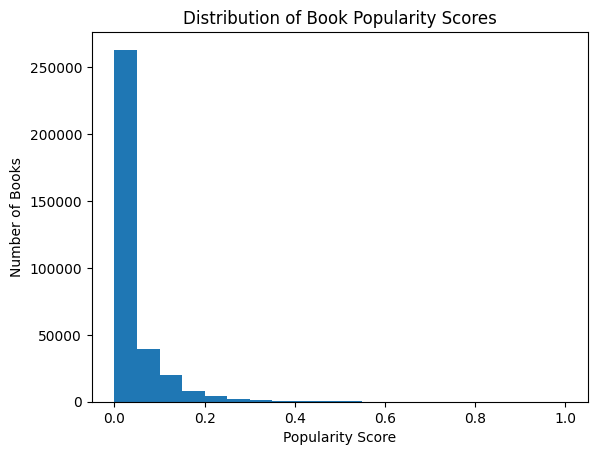

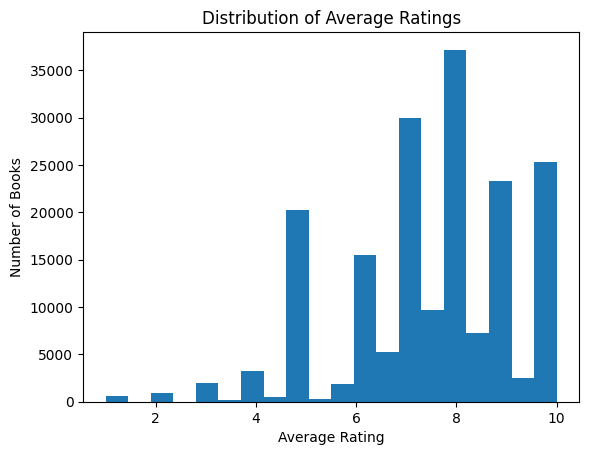

Popularity category distribution:
popularity_cat
Very_Low     330472
Low            8846
Medium         1114
High            121
Very_High         3
Name: count, dtype: int64
Rating category distribution:
rating_cat
Unrated                          154583
Very_good_LowSupport              37655
Fair_LowSupport                   35085
Good_LowSupport                   29846
Perfect_LowSupport                26669
Excellent_LowSupport              26301
Poor_LowSupport                    3679
Mediocre_LowSupport                3477
Very_good_LowSupport_HighVar       3294
Very_good_MedSupport               2953
Good_LowSupport_HighVar            2948
Very_good_MedSupport_HighVar       2388
Good_MedSupport_HighVar            2347
Fair_LowSupport_HighVar            1873
Good_MedSupport                    1575
Excellent_MedSupport               1548
Very_good_HighSupport_HighVar       863
Fair_MedSupport_HighVar             670
Good_HighSupport_HighVar            494
Very_good_HighSupport   

,isbn,r_total,r_count,r_avg,r_std,recent_count,popularity,popularity_cat,rating_cat,rating_score,rating_cat_simple
0,0330299891,2,1,6.0,0.0,0,0.024174,Very_Low,Fair_LowSupport,0.498643,Mediocre
1,0375404120,2,1,3.0,0.0,0,0.024174,Very_Low,Poor_LowSupport,0.265310,Poor
2,0586045007,1,0,NaN,NaN,0,0.000000,Very_Low,Unrated,NaN,Unrated
3,9022906116,2,1,7.0,0.0,1,0.106826,Very_Low,Good_LowSupport,0.576421,Fair
4,9032803328,1,0,NaN,NaN,0,0.000000,Very_Low,Unrated,NaN,Unrated
5,9044922564,1,0,NaN,NaN,0,0.000000,Very_Low,Unrated,NaN,Unrated
6,9044922572,1,0,NaN,NaN,0,0.000000,Very_Low,Unrated,NaN,Unrated
7,9044922718,1,0,NaN,NaN,0,0.000000,Very_Low,Unrated,NaN,Unrated
8,9044923161,1,0,NaN,NaN,1,0.082652,Very_Low,Unrated,NaN,Unrated
9,904492401X,1,0,NaN,NaN,0,0.000000,Very_Low,Unrated,NaN,Unrated



=== BOOKS WITH METRICS CSV DIAGNOSTICS ===
Books with metrics rows: 266,457
Sample of books with metrics:


,isbn,title,authors,publication_year,publisher,image_url_s,image_url_m,image_url_l,description,price_usd,...,r_total,r_count,r_avg,r_std,recent_count,popularity,popularity_cat,rating_cat,rating_score,rating_cat_simple
0,0195153448,Classical Mythology,['Mark P. O. Morford'],2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,NaN,NaN,...,1,0,NaN,NaN,0,0.000000,Very_Low,Unrated,NaN,Unrated
1,0002005018,Clara Callan,['Richard Bruce Wright'],2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,NaN,NaN,...,14,9,7.666667,1.333333,1,0.202782,Low,Very_good_MedSupport,0.624326,Good
2,0060973129,Decision in Normandy,"[""Carlo D'Este""]",1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,NaN,NaN,...,3,2,7.500000,0.500000,0,0.041326,Very_Low,Very_good_LowSupport,0.599588,Fair
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,['Gina Bari Kolata'],1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,NaN,NaN,...,11,6,7.833333,1.462494,2,0.237827,Low,Very_good_MedSupport,0.610193,Fair
4,0393045218,The Mummies of Urumchi,['E. J. W. Barber'],1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,NaN,NaN,...,1,0,NaN,NaN,0,0.000000,Very_Low,Unrated,NaN,Unrated
5,0399135782,The Kitchen God's Wife,['Amy Tan'],1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,NaN,NaN,...,33,17,8.176471,1.504319,1,0.251571,Low,Very_good_MedSupport_HighVar,0.697471,Good
6,0425176428,What If?: The World's Foremost Military Histor...,['Robert Cowley'],2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,NaN,NaN,...,5,1,8.000000,0.000000,0,0.065500,Very_Low,Very_good_LowSupport,0.654199,Good
7,0671870432,PLEADING GUILTY,['Scott Turow'],1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,NaN,NaN,...,3,1,8.000000,0.000000,0,0.041326,Very_Low,Very_good_LowSupport,0.654199,Good
8,0679425608,Under the Black Flag: The Romance and the Real...,['David Cordingly'],1996,Random House,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...,“This is the most authoritative and highly lit...,27.13,...,1,0,NaN,NaN,0,0.000000,Very_Low,Unrated,NaN,Unrated
9,074322678X,Where You'll Find Me: And Other Stories,['Ann Beattie'],2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,NaN,NaN,...,1,1,5.000000,0.000000,0,0.000000,Very_Low,Fair_LowSupport,0.420865,Mediocre


Current columns: ['isbn', 'title', 'authors', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l', 'description', 'price_usd', 'price_is_synthetic', 'genre', 'sub_genres', 'root_genres', 'image_alternative', 'previewlink', 'infolink', 'r_total', 'r_count', 'r_avg', 'r_std', 'recent_count', 'popularity', 'popularity_cat', 'rating_cat', 'rating_score', 'rating_cat_simple']
New columns: ['isbn', 'title', 'authors', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l', 'description', 'price_usd', 'price_is_synthetic', 'genre', 'sub_genres', 'root_genres', 'image_alternative', 'previewlink', 'infolink', 'rating_score', 'r_category', 'popularity', 'popularity_cat', 'r_total', 'r_count', 'r_avg', 'r_std', 'recent_count']


/tmp/ipykernel_1196834/1302936987.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_final.rename(columns={'rating_cat_simple': 'r_category'}, inplace=True)


Saved books with metrics -> /book_rec_project/data/processed/books.csv (266,457 rows)


In [ ]:
import math
import json

# -- params you can tune
RECENT_WINDOW_FRAC = 0.05   # fraction of most-recent interactions to treat as "recent"
RANDOM_STATE = 42
# Deterministic global shuffle + control over per-user / per-book sequences
RECOMPUTE_SEQS = True   # set False to keep original sequences (pre-shuffle) in r_seq_user_orig / r_seq_book_orig

# Load raw ratings (do not drop rows here so r_total counts implicit engagements)
ratings_raw_path = interim_dir / "ratings_cleaned.csv"
if not ratings_raw_path.exists():
    ratings_raw_path = Path("../data/interim/ratings_cleaned.csv")
ratings_raw = pd.read_csv(ratings_raw_path, low_memory=False, encoding="utf-8")

explicit_mask = ratings_raw['rating'] > 0

# Basic counts and aggregates
r_total = ratings_raw.groupby('isbn').size().rename('r_total')                    # all interactions (implicit+explicit)
r_count = ratings_raw[explicit_mask].groupby('isbn').size().rename('r_count')     # explicit rating count
r_avg   = ratings_raw[explicit_mask].groupby('isbn')['rating'].mean().rename('r_avg')
r_std   = ratings_raw[explicit_mask].groupby('isbn')['rating'].std(ddof=0).rename('r_std')

metrics = pd.concat([r_total, r_count, r_avg, r_std], axis=1).reset_index()
metrics['r_count'] = metrics['r_count'].fillna(0).astype(int)
metrics['r_total'] = metrics['r_total'].fillna(0).astype(int)
# keep r_avg/r_std as float (NaN if no explicit ratings)

# ensure stable baseline
ratings_raw = ratings_raw.reset_index(drop=True)

# keep original sequences in case you want them later (they reflect current file order)
ratings_raw['r_seq_user_orig'] = ratings_raw.groupby('user_id').cumcount() + 1
ratings_raw['r_seq_book_orig'] = ratings_raw.groupby('isbn').cumcount() + 1

# Deterministic global shuffle for recency/popularity signal
shuffled = ratings_raw.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
shuffled['ratings_seq'] = shuffled.index + 1
max_seq = int(shuffled['ratings_seq'].max())
recent_cutoff = int(max(1, max_seq * (1.0 - RECENT_WINDOW_FRAC)))

# Decide sequences to use: recompute so they follow the new shuffled order (recommended),
# or reuse original sequences saved above.
if RECOMPUTE_SEQS:
    shuffled['r_seq_user'] = shuffled.groupby('user_id').cumcount() + 1
    shuffled['r_seq_book'] = shuffled.groupby('isbn').cumcount() + 1
else:
    shuffled['r_seq_user'] = shuffled['r_seq_user_orig']
    shuffled['r_seq_book'] = shuffled['r_seq_book_orig']

# use shuffled ordering to compute recent counts / last_seq (popularity)
recent_counts = shuffled[shuffled['ratings_seq'] > recent_cutoff].groupby('isbn').size().rename('recent_count')
last_seq = shuffled.groupby('isbn')['ratings_seq'].max().rename('last_seq')

# If you no longer need the original sequences, drop the helper columns:
shuffled = shuffled.drop(columns=['r_seq_user_orig','r_seq_book_orig'], errors='ignore')
print(f"Ratings data after shuffle and sequence recompute: {len(shuffled):,} rows")
display(shuffled.head(10))


metrics = metrics.merge(recent_counts.reset_index(), on='isbn', how='left')
metrics = metrics.merge(last_seq.reset_index(), on='isbn', how='left')
metrics['recent_count'] = metrics['recent_count'].fillna(0).astype(int)
metrics['last_seq'] = metrics['last_seq'].fillna(0).astype(int)

# Simple popularity score (tunable)
# combine long-term engagement (r_total) with short-term recency (recent_count)
metrics['pop_raw'] = (metrics['r_total'].apply(lambda x: math.log1p(x)) +
                      2.0 * metrics['recent_count'].apply(lambda x: math.log1p(x)))

# normalize pop_raw 0..1
if metrics['pop_raw'].max() > metrics['pop_raw'].min():
    metrics['popularity'] = (metrics['pop_raw'] - metrics['pop_raw'].min()) / (metrics['pop_raw'].max() - metrics['pop_raw'].min())
    # define populatiry categories:
    if 'popularity_cat' not in metrics.columns:
        def pop_bucket(v):
            if v >= 0.8:
                return 'Very_High'
            if v >= 0.6:
                return 'High'
            if v >= 0.4:
                return 'Medium'
            if v >= 0.2:
                return 'Low'
            if v > 0.0:
                return 'Very_Low'
            return 'Not_popular'
        metrics['popularity_cat'] = metrics['popularity'].apply(pop_bucket)
else:
    metrics['popularity'] = 0.0
    if 'popularity_cat' not in metrics.columns:
        metrics['popularity_cat'] = 'Not_popular'

# Dist of popularity:
import matplotlib.pyplot as plt
plt.hist(metrics['popularity'].dropna(), bins=20)
plt.xlabel('Popularity Score')
plt.ylabel('Number of Books')
plt.title('Distribution of Book Popularity Scores')
plt.show()

# drop helpers:
metrics = metrics.drop(columns=['pop_raw','last_seq'], errors='ignore')

# See actual distribution of avg ratings:
plt.hist(metrics['r_avg'].dropna(), bins=20)
plt.xlabel('Average Rating')
plt.ylabel('Number of Books')
plt.title('Distribution of Average Ratings')
plt.show()
# Pop cat dist:
print("Popularity category distribution:")
print(metrics['popularity_cat'].value_counts())

# Rating category buckets (use avg rating plus support/variance signals: r_count, r_total, r_std)
def rating_bucket(row):
    """
    Return a compact rating category that incorporates:
      - base quality (r_avg),
      - support (r_count / r_total) translated to Low/Med/High support,
      - optional high-variance marker if r_std is large.

    Produces labels like: 'Excellent_LowSupport', 'Good_HighSupport_HighVar', 'Unrated'
    """
    try:
        if pd.isna(row.get('r_avg')):
            return 'Unrated'
        v = float(row.get('r_avg'))
        # base bucket by average
        if v >= 9.5:
            base = 'Perfect'
        elif v >= 8.5:
            base = 'Excellent'
        elif v >= 7.5:
            base = 'Very_good'
        elif v >= 6.5:
            base = 'Good'
        elif v >= 5.0:
            base = 'Fair'
        elif v >= 4.0:
            base = 'Mediocre'
        else:
            base = 'Poor'

        # support level from explicit rating count (r_count) -- treat <5 as low confidence
        count = int(row.get('r_count') or 0)
        total = int(row.get('r_total') or 0)
        if count < 5:
            support = 'LowSupport'
        elif count < 20:
            support = 'MedSupport'
        else:
            support = 'HighSupport'

        # high variance marker (r_std) to indicate disagreement among raters
        std = row.get('r_std')
        high_var = ''
        try:
            if not pd.isna(std) and float(std) > 1.5:
                high_var = '_HighVar'
        except Exception:
            high_var = ''

        return f"{base}_{support}{high_var}"
    except Exception:
        return 'Unrated'

# apply to rows so the function can access r_count/r_total/r_std
metrics['rating_cat'] = metrics.apply(rating_bucket, axis=1)
# Rating cat dist:
print("Rating category distribution:")
print(metrics['rating_cat'].value_counts())

def simple_rating_score(row,
                        w_avg=0.7,      # weight on mean rating (r_avg)
                        w_support=0.2,  # weight on support (r_count)
                        w_std=0.1,      # weight on confidence (inverse of std)
                        support_scale=20.0,  # scale for support saturation
                        std_scale=2.0):      # std at which penalty ~=1
    """
    Compute a compact 0..1 score combining:
      - r_avg (assumed on 1..10 scale),
      - support from explicit count r_count (more votes => higher support),
      - penalty from high std (disagreement reduces score).

    Returns tuple: (score_float, category_str)
    """
    try:
        if pd.isna(row.get('r_avg')):
            return (float('nan'), 'Unrated')
        # normalize avg to 0..1 (rating scale 1..10)
        r_avg = float(row.get('r_avg'))
        avg_norm = max(0.0, min(1.0, (r_avg - 1.0) / 9.0))

        r_count = int(row.get('r_count') or 0)
        # support factor: quick saturating transform (0..1)
        support = 1.0 - math.exp(- (r_count / float(support_scale)))

        # std penalty: map std to [0,1], higher std => larger penalty
        std = row.get('r_std')
        std_pen = 0.0
        if not pd.isna(std):
            std_val = float(std)
            std_pen = min(1.0, std_val / float(std_scale))

        # combine (note std contributes as confidence = 1 - std_pen)
        score = (w_avg * avg_norm +
                 w_support * support +
                 w_std * (1.0 - std_pen))

        # clamp defensively
        score = max(0.0, min(1.0, score))

        # map to compact categories (simple / non-verbose)
        if score >= 0.92:
            cat = 'Perfect'
        elif score >= 0.82:
            cat = 'Excellent'
        elif score >= 0.72:
            cat = 'Very_good'
        elif score >= 0.62:
            cat = 'Good'
        elif score >= 0.52:
            cat = 'Fair'
        elif score >= 0.42:
            cat = 'Mediocre'
        else:
            cat = 'Poor'

        return (score, cat)
    except Exception:
        return (float('nan'), 'Unrated')

# apply to metrics DF: produce numeric score + simple category
metrics[['rating_score', 'rating_cat_simple']] = metrics.apply(
    lambda r: pd.Series(simple_rating_score(r)), axis=1)

# Dist of simple rating categories:
print(metrics['rating_cat_simple'].value_counts())

print("\n=== BOOK RATING METRICS CSV DIAGNOSTICS ===")
print(f"Books with rating metrics rows: {len(metrics):,}")
print("Sample of book rating metrics:")
display(metrics.head(25))

# Merge metrics into books with genres (left join so every book keeps its row)

books_path = interim_dir / "books_genres.csv"
books = pd.read_csv(books_path, dtype=str, low_memory=False)
books_with_metrics = books.merge(metrics, on='isbn', how='left', validate='1:1')


# Fill missing numeric metrics with sensible defaults
books_with_metrics['r_total'] = books_with_metrics['r_total'].fillna(0).astype(int)
books_with_metrics['r_count'] = books_with_metrics['r_count'].fillna(0).astype(int)
books_with_metrics['recent_count'] = books_with_metrics['recent_count'].fillna(0).astype(int)
books_with_metrics['popularity'] = books_with_metrics['popularity'].fillna(0.0).astype(float)
# keep r_avg / r_std as floats (NaN when no explicit ratings)

print("\n=== BOOKS WITH METRICS CSV DIAGNOSTICS ===")
print(f"Books with metrics rows: {len(books_with_metrics):,}")
print("Sample of books with metrics:")
display(books_with_metrics.head(10))

print(f"Current columns: {list(books_with_metrics.columns)}")
filter_col = ['isbn', 'title', 'authors', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l', 'description', 'price_usd', 'price_is_synthetic', 'genre', 'sub_genres', 'root_genres', 'image_alternative', 'previewlink', 'infolink', 'rating_score', 'rating_cat_simple', 'popularity', 'popularity_cat', 'r_total', 'r_count', 'r_avg', 'r_std', 'recent_count']
books_final = books_with_metrics[filter_col]
books_final.rename(columns={'rating_cat_simple': 'r_category'}, inplace=True)
print(f"New columns: {list(books_final.columns)}")

process_dir = Path("../data/processed")
# Save books with and without metrics for convenience
out_path = process_dir / "books.csv"
books_final.to_csv(out_path, index=False, encoding='utf-8')
rel_out = _compute_relative_target_dir(out_path)
print(f"Saved books with metrics -> {rel_out} ({len(books_final):,} rows)")

In [25]:
ratings = pd.read_csv('../data/processed/ratings.csv', dtype=str, low_memory=False)
ratings_isbn = list(ratings['isbn'].unique())
print(f"Total unique books in processed ratings data: {len(ratings_isbn):,} ({len(ratings_isbn) / len(book_isbns):.2%} of books)")
book_ratings = ratings[ratings['isbn'].isin(book_isbns)]
num_ratings = book_ratings.shape[0]
print(f"Total ratings for books in processed data: {num_ratings:,} ({num_ratings / ratings.shape[0]:.2%} of ratings)")

Total unique books in processed ratings data: 340,556 (127.81% of books)
Total ratings for books in processed data: 1,016,676 (88.42% of ratings)


In [26]:
import math
import json
import ast
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter

# -- params you can tune
RECENT_WINDOW_FRAC = 0.1  # fraction of most-recent interactions to treat as "recent"
RANDOM_STATE = 42
# Deterministic global shuffle + control over per-user / per-book sequences
RECOMPUTE_SEQS = True   # set False to keep original sequences (pre-shuffle) in r_seq_user_orig / r_seq_book_orig

# --- Regional identifiers ---
regional_identifiers = {
    # North America
    'American': ['American', 'United States', 'U.S.', 'USA'],
    'Canadian': ['Canadian', 'Canada'],
    'Mexican': ['Mexican', 'Mexico'],
    
    # British Isles
    'English': ['English', 'England'],
    'British': ['British', 'Britain', 'Great Britain'],
    'Irish': ['Irish', 'Ireland'],
    'Scottish': ['Scottish', 'Scotland'],
    'Welsh': ['Welsh', 'Wales'],
    
    # Western Europe
    'French': ['French', 'France'],
    'German': ['German', 'Germany', 'Germanic'],
    'Italian': ['Italian', 'Italy'],
    'Spanish': ['Spanish', 'Spain'],
    'Portuguese': ['Portuguese', 'Portugal'],
    'Dutch': ['Dutch', 'Netherlands', 'Holland'],
    'Belgian': ['Belgian', 'Belgium'],
    'Swiss': ['Swiss', 'Switzerland'],
    'Austrian': ['Austrian', 'Austria'],
    
    # Northern Europe
    'Swedish': ['Swedish', 'Sweden'],
    'Norwegian': ['Norwegian', 'Norway'],
    'Danish': ['Danish', 'Denmark'],
    'Finnish': ['Finnish', 'Finland'],
    'Icelandic': ['Icelandic', 'Iceland'],
    
    # Eastern Europe
    'Russian': ['Russian', 'Russia'],
    'Polish': ['Polish', 'Poland'],
    'Czech': ['Czech', 'Czechoslovakia'],
    'Hungarian': ['Hungarian', 'Hungary'],
    'Romanian': ['Romanian', 'Romania'],
    'Ukrainian': ['Ukrainian', 'Ukraine'],
    
    # Southern Europe
    'Greek': ['Greek', 'Greece'],
    'Turkish': ['Turkish', 'Turkey'],
    
    # Asia
    'Japanese': ['Japanese', 'Japan'],
    'Chinese': ['Chinese', 'China'],
    'Korean': ['Korean', 'Korea'],
    'Indian': ['Indian', 'India', 'Indic'],
    'Thai': ['Thai', 'Thailand'],
    'Vietnamese': ['Vietnamese', 'Vietnam'],
    'Indonesian': ['Indonesian', 'Indonesia'],
    'Filipino': ['Filipino', 'Philippine', 'Philippines'],
    
    # Middle East
    'Israeli': ['Israeli', 'Israel'],
    'Iranian': ['Iranian', 'Iran', 'Persian'],
    'Arab': ['Arab', 'Arabic'],
    'Egyptian': ['Egyptian', 'Egypt'],
    
    # Oceania
    'Australian': ['Australian', 'Australia'],
    'New Zealand': ['New Zealand', 'Kiwi'],
    
    # Africa
    'South African': ['South African', 'South Africa'],
    'Nigerian': ['Nigerian', 'Nigeria'],
    'Kenyan': ['Kenyan', 'Kenya'],
    
    # Latin America
    'Brazilian': ['Brazilian', 'Brazil'],
    'Argentine': ['Argentine', 'Argentina'],
    'Chilean': ['Chilean', 'Chile'],
    'Colombian': ['Colombian', 'Colombia'],
    'Peruvian': ['Peruvian', 'Peru'],
    'Cuban': ['Cuban', 'Cuba'],
    
    # Caribbean
    'Jamaican': ['Jamaican', 'Jamaica'],
    'Caribbean': ['Caribbean'],
}

def extract_regional_tags_from_text(text: str) -> list:
    """Extract region tags from any text (genre or title)."""
    if not text or pd.isna(text):
        return []
    
    lowered = str(text).lower()
    found_regions = []
    
    for region, identifiers in regional_identifiers.items():
        if any(identifier.lower() in lowered for identifier in identifiers):
            found_regions.append(region)
    
    return found_regions

def safe_parse_genre(value):
    """Safely parse genre string/list into list of strings."""
    if pd.isna(value):
        return []
    if isinstance(value, list):
        return [str(g).strip() for g in value if str(g).strip()]
    text = str(value).strip()
    if not text:
        return []
    try:
        parsed = ast.literal_eval(text)
        if isinstance(parsed, list):
            return [str(g).strip() for g in parsed if str(g).strip()]
    except Exception:
        pass
    if "," in text:
        return [p.strip() for p in text.split(",") if p.strip()]
    return [text]

def resolve_regional_contradictions(genre_regions: list, title_regions: list) -> list:
    """
    Resolve contradictions between genre and title regional tags.
    Strategy:
    1. If both agree or one is empty, combine them
    2. If they contradict, use weighted voting (genre gets 2x weight)
    3. Keep regions that appear in either source but flag contradictions
    """
    if not genre_regions and not title_regions:
        return None
    
    if not genre_regions:
        return sorted(set(title_regions)) if title_regions else None
    
    if not title_regions:
        return sorted(set(genre_regions)) if genre_regions else None
    
    # Count occurrences with weights
    region_votes = Counter()
    
    # Genre regions get 2x weight (more reliable)
    for region in genre_regions:
        region_votes[region] += 2
    
    # Title regions get 1x weight
    for region in title_regions:
        region_votes[region] += 1
    
    # If we have multiple regions with different votes, keep top ones
    # But keep all if votes are close (within 1 point)
    if len(region_votes) > 1:
        max_votes = max(region_votes.values())
        # Keep regions with votes >= max - 1 (to handle close calls)
        selected_regions = [r for r, v in region_votes.items() if v >= max_votes - 1]
    else:
        selected_regions = list(region_votes.keys())
    
    return sorted(set(selected_regions)) if selected_regions else None

def map_genre_with_metadata(genre_str, title_str, genre_mapping):
    """
    Turn the stored genre string into root/sub/region lists.
    Extract regions from both genre AND title, then resolve contradictions.
    Returns None for missing data to keep sparse structure.
    """
    genres = safe_parse_genre(genre_str)
    
    if not genres and (not title_str or pd.isna(title_str)):
        return {'root_genres': None, 'subgenres': None, 'regional_tags': None}

    roots, subs = set(), set()
    genre_regions = set()
    
    # Extract from genres
    for genre in genres:
        info = genre_mapping.get(genre)
        if info:
            roots.update(info['root_genres'])
            subs.update(info['subgenres'])
            # Extract regions from genre names
            genre_regions.update(extract_regional_tags_from_text(genre))
    
    # Extract regions from title
    title_regions = set(extract_regional_tags_from_text(title_str))
    
    # Resolve contradictions between genre and title regions
    resolved_regions = resolve_regional_contradictions(
        list(genre_regions), 
        list(title_regions)
    )
    
    # If we got nothing meaningful, return None structure
    if not (roots or subs or resolved_regions):
        return {'root_genres': None, 'subgenres': None, 'regional_tags': None}
    
    return {
        'root_genres': sorted(roots) if roots else None,
        'subgenres': sorted(subs) if subs else None,
        'regional_tags': resolved_regions,
    }


# Build genre mapping once
interim_dir = Path("../data/interim")
genre_json_path = interim_dir / "genre_tree.json"
with open(genre_json_path, "r", encoding="utf-8") as fh:
    genre_data = json.load(fh)
genre_hierarchy = genre_data.get("genre_hierarchy", {})

def build_genre_mapping(hierarchy: dict) -> dict:
    """Map every raw genre token to root/sub genres it belongs to."""
    mapping = {}
    for root, subcats in (hierarchy or {}).items():
        if not isinstance(subcats, dict):
            continue
        for sub_name, raw_values in subcats.items():
            if not isinstance(raw_values, list):
                continue
            for raw in raw_values:
                entry = mapping.setdefault(raw, {'root_genres': [], 'subgenres': []})
                if root not in entry['root_genres']:
                    entry['root_genres'].append(root)
                if sub_name not in entry['subgenres']:
                    entry['subgenres'].append(sub_name)
    return mapping

genre_mapping = build_genre_mapping(genre_hierarchy)
print(f"Genre mapping built with {len(genre_mapping):,} entries")

# Load data

books_path = interim_dir / "books_genres.csv"
books = pd.read_csv(books_path, dtype=str, low_memory=False)

# get unique isbn in books and drop the remaining in ratings
book_isbn = list(books['isbn'].unique())

ratings_raw_path = interim_dir / "ratings_cleaned.csv"
ratings_raw = pd.read_csv(ratings_raw_path, low_memory=False, encoding="utf-8")
num_rat_before = ratings_raw.shape[0]
ratings_raw = ratings_raw[ratings_raw['isbn'].isin(book_isbn)]
num_rat_after = ratings_raw.shape[0]
print(f"Filtered ratings data to books: {num_rat_before:,} -> {num_rat_after:,} rows")
print(f"    - Removed {num_rat_before - num_rat_after:,} ratings for books not in books dataset, {((num_rat_before - num_rat_after) / num_rat_before):.2%} of initial set.")

explicit_mask = ratings_raw['rating'] > 0

# Basic counts and aggregates
r_total = ratings_raw.groupby('isbn').size().rename('r_total')
r_count = ratings_raw[explicit_mask].groupby('isbn').size().rename('r_count')
r_avg   = ratings_raw[explicit_mask].groupby('isbn')['rating'].mean().rename('r_avg')
r_std   = ratings_raw[explicit_mask].groupby('isbn')['rating'].std(ddof=0).rename('r_std')

metrics = pd.concat([r_total, r_count, r_avg, r_std], axis=1).reset_index()

# ensure stable baseline
ratings_raw = ratings_raw.reset_index(drop=True)

# keep original sequences
ratings_raw['r_seq_user_orig'] = ratings_raw.groupby('user_id').cumcount() + 1
ratings_raw['r_seq_book_orig'] = ratings_raw.groupby('isbn').cumcount() + 1

# Deterministic global shuffle
ratings_shuffled = ratings_raw.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
ratings_shuffled['ratings_seq'] = ratings_shuffled.index + 1
max_seq = int(ratings_shuffled['ratings_seq'].max())
recent_cutoff = int(max(1, max_seq * (1.0 - RECENT_WINDOW_FRAC)))

if RECOMPUTE_SEQS:
    ratings_shuffled['r_seq_user'] = ratings_shuffled.groupby('user_id').cumcount() + 1
    ratings_shuffled['r_seq_book'] = ratings_shuffled.groupby('isbn').cumcount() + 1
else:
    ratings_shuffled['r_seq_user'] = ratings_shuffled['r_seq_user_orig']
    ratings_shuffled['r_seq_book'] = ratings_shuffled['r_seq_book_orig']

recent_counts = ratings_shuffled[ratings_shuffled['ratings_seq'] > recent_cutoff].groupby('isbn').size().rename('recent_count')
last_seq = ratings_shuffled.groupby('isbn')['ratings_seq'].max().rename('last_seq')

print("Ratings data before dropping original sequences:")
display(ratings_shuffled.head(10))
ratings_shuffled = ratings_shuffled.drop(columns=['r_seq_user_orig','r_seq_book_orig'], errors='ignore')
print(f"Ratings data after shuffle:")
display(ratings_shuffled.head(10))

metrics = metrics.merge(recent_counts.reset_index(), on='isbn', how='left')
metrics = metrics.merge(last_seq.reset_index(), on='isbn', how='left')
metrics['recent_count'] = metrics['recent_count'].fillna(0).astype(int)
metrics['last_seq'] = metrics['last_seq'].fillna(0).astype(int)

# Simple popularity score
metrics['pop_raw'] = (metrics['r_total'].apply(lambda x: math.log1p(x)) +
                      2.0 * metrics['recent_count'].apply(lambda x: math.log1p(x)))

if metrics['pop_raw'].max() > metrics['pop_raw'].min():
    metrics['popularity'] = (metrics['pop_raw'] - metrics['pop_raw'].min()) / (metrics['pop_raw'].max() - metrics['pop_raw'].min())
    
    def pop_bucket(v):
        if v >= 0.8:
            return 'Very_High'
        if v >= 0.6:
            return 'High'
        if v >= 0.4:
            return 'Medium'
        if v >= 0.2:
            return 'Low'
        if v > 0.0:
            return 'Very_Low'
        return 'Not_popular'
    metrics['popularity_cat'] = metrics['popularity'].apply(pop_bucket)
else:
    metrics['popularity'] = 0.0
    metrics['popularity_cat'] = 'Not_popular'

metrics = metrics.drop(columns=['pop_raw','last_seq'], errors='ignore')

def simple_rating_score(row,
                        w_avg=0.7,
                        w_support=0.2,
                        w_std=0.1,
                        support_scale=20.0,
                        std_scale=2.0):
    try:
        if pd.isna(row.get('r_avg')):
            return (float('nan'), 'Unrated')
        
        r_avg = float(row.get('r_avg'))
        avg_norm = max(0.0, min(1.0, (r_avg - 1.0) / 9.0))

        r_count = int(row.get('r_count') or 0)
        support = 1.0 - math.exp(- (r_count / float(support_scale)))

        std = row.get('r_std')
        std_pen = 0.0
        if not pd.isna(std):
            std_val = float(std)
            std_pen = min(1.0, std_val / float(std_scale))

        score = (w_avg * avg_norm + w_support * support + w_std * (1.0 - std_pen))
        score = max(0.0, min(1.0, score))

        if score >= 0.92:
            cat = 'Perfect'
        elif score >= 0.82:
            cat = 'Excellent'
        elif score >= 0.72:
            cat = 'Very_good'
        elif score >= 0.62:
            cat = 'Good'
        elif score >= 0.52:
            cat = 'Fair'
        elif score >= 0.42:
            cat = 'Mediocre'
        else:
            cat = 'Poor'

        return (score, cat)
    except Exception:
        return (float('nan'), 'Unrated')

metrics[['rating_score', 'r_category']] = metrics.apply(
    lambda r: pd.Series(simple_rating_score(r)), axis=1)

print("\n=== BOOK RATING METRICS ===")
print(f"Books with rating metrics: {len(metrics):,}")

books_with_metrics = books.merge(metrics, on='isbn', how='left', validate='1:1')

# Fill missing numeric metrics
books_with_metrics['recent_count'] = books_with_metrics['recent_count'].fillna(0).astype(int)
books_with_metrics['r_category'] = books_with_metrics['r_category'].fillna('Unrated')
books_with_metrics['popularity_cat'] = books_with_metrics['popularity_cat'].fillna('Not_popular')
books_with_metrics['r_count'] = books_with_metrics['r_count'].fillna(0).astype(int)
books_with_metrics['r_total'] = books_with_metrics['r_total'].fillna(0).astype(int)
books_with_metrics['popularity'] = books_with_metrics['popularity'].fillna(0.0).astype(float)
# keep r_avg / r_std as floats (NaN when no explicit ratings)

print(f"✓ Filled missing r_category: {(books_with_metrics['r_category'] == 'Unrated').sum():,} books")
print(f"✓ Filled missing popularity_cat: {(books_with_metrics['popularity_cat'] == 'Not_popular').sum():,} books")

# Apply genre enrichment with regional tags from BOTH genre and title
print("\n=== ENRICHING BOOKS WITH REGIONAL TAGS (from genre + title) ===")
genre_metadata = books_with_metrics.apply(
    lambda row: map_genre_with_metadata(row['genre'], row['title'], genre_mapping), 
    axis=1
)

books_with_metrics['root_genres_enriched'] = genre_metadata.apply(lambda x: x['root_genres'])
books_with_metrics['subgenres_enriched'] = genre_metadata.apply(lambda x: x['subgenres'])
books_with_metrics['regional_tags'] = genre_metadata.apply(lambda x: x['regional_tags'])

# Convert empty lists and None to NaN
def clean_genre_field(value):
    """Convert None, empty lists, or empty strings to NaN"""
    if value is None:
        return np.nan
    if isinstance(value, list) and len(value) == 0:
        return np.nan
    if isinstance(value, str) and value.strip() == '':
        return np.nan
    return value

# Apply cleaning to all genre-related columns
for col in ['root_genres_enriched', 'subgenres_enriched', 'regional_tags', 'root_genres', 'sub_genres']:
    if col in books_with_metrics.columns:
        books_with_metrics[col] = books_with_metrics[col].apply(clean_genre_field)

print(f"Books with regional tags: {books_with_metrics['regional_tags'].notna().sum():,}")
print(f"Books with root genres: {books_with_metrics['root_genres_enriched'].notna().sum():,}")
print(f"Books with subgenres: {books_with_metrics['subgenres_enriched'].notna().sum():,}")

# Show examples of regional tag extraction
print("\n=== SAMPLE REGIONAL TAG EXTRACTION ===")
sample_with_regions = books_with_metrics[books_with_metrics['regional_tags'].notna()].head(10)
for idx, row in sample_with_regions.iterrows():
    print(f"\nTitle: {row['title']}")
    print(f"Genre: {row['genre']}")
    print(f"Regional Tags: {row['regional_tags']}")

# Select final columns
filter_col = ['isbn', 'title', 'authors', 'publication_year', 'publisher', 
              'image_url_s', 'image_url_m', 'image_url_l', 'description', 
              'price_usd', 'price_is_synthetic', 'genre', 
              'root_genres_enriched', 'subgenres_enriched', 'regional_tags',
              'image_alternative', 'previewlink', 'infolink', 
              'rating_score', 'r_category', 'popularity', 'popularity_cat', 
              'r_total', 'r_count', 'r_avg', 'r_std', 'recent_count']

books_final = books_with_metrics[filter_col]

# Rename to clean names
books_final = books_final.rename(columns={
    'root_genres_enriched': 'root_genres',
    'subgenres_enriched': 'subgenres'
})

print(f"\nFinal columns: {list(books_final.columns)}")
print("Sample of final books dataframe:")
display(books_final.head())

# Summary of missing data
print("\n=== FINAL BOOKS DATAFRAME MISSING DATA SUMMARY ===\n")
summary = {'columm' : [], 'missing_count': [], 'missing_perct': []}
for col in books_final.columns:
    missing_count = books_final[col].isna().sum()
    summary['columm'].append(col)
    summary['missing_count'].append(missing_count)
    summary['missing_perct'].append(round((missing_count / len(books_final) * 100), 2))
summary_df = pd.DataFrame(summary)
display(summary_df)

# Save final books CSV with metrics and regional tags
save = True
files_to_save = {
    "books.csv": books_final,
    "ratings.csv": ratings_shuffled
}
if save:

    process_dir = Path("../data/processed")
    process_dir.mkdir(parents=True, exist_ok=True)
    for filename, df in files_to_save.items():
        out_path = process_dir / filename
        df.to_csv(out_path, index=False, encoding='utf-8')
        print(f"\n✓ Saved {filename} -> {out_path} ({len(df):,} rows)")
else:
    print(f"\nsave=False -> no file written. Set save=True and re-run to persist CSV files ({', '.join(files_to_save.keys())}).")

Genre mapping built with 1,534 entries
Filtered ratings data to books: 1,149,780 -> 1,016,676 rows
    - Removed 133,104 ratings for books not in books dataset, 11.58% of initial set.
Ratings data before dropping original sequences:


,user_id,isbn,rating,r_seq_user,r_seq_book,r_cat,r_seq_user_orig,r_seq_book_orig,ratings_seq
0,268134,0393029190,0,1,1,not_rated,17,11,1
1,86548,0060964316,10,1,1,very_high,2,1,2
2,270660,0609803794,0,1,1,not_rated,11,3,3
3,148744,0140089357,0,1,1,not_rated,98,1,4
4,125774,0439139597,0,1,1,not_rated,219,86,5
5,152345,0865163529,5,1,1,mid,10,1,6
6,55492,0671034111,0,1,1,not_rated,1811,2,7
7,228154,0345361326,6,1,1,mid,1,14,8
8,96448,0064472272,10,1,1,very_high,15,39,9
9,129358,0380820854,0,1,1,not_rated,1139,16,10


Ratings data after shuffle:


,user_id,isbn,rating,r_seq_user,r_seq_book,r_cat,ratings_seq
0,268134,0393029190,0,1,1,not_rated,1
1,86548,0060964316,10,1,1,very_high,2
2,270660,0609803794,0,1,1,not_rated,3
3,148744,0140089357,0,1,1,not_rated,4
4,125774,0439139597,0,1,1,not_rated,5
5,152345,0865163529,5,1,1,mid,6
6,55492,0671034111,0,1,1,not_rated,7
7,228154,0345361326,6,1,1,mid,8
8,96448,0064472272,10,1,1,very_high,9
9,129358,0380820854,0,1,1,not_rated,10



=== BOOK RATING METRICS ===
Books with rating metrics: 265,181
✓ Filled missing r_category: 119,511 books
✓ Filled missing popularity_cat: 129,683 books

=== ENRICHING BOOKS WITH REGIONAL TAGS (from genre + title) ===
Books with regional tags: 14,268
Books with root genres: 12,666
Books with subgenres: 12,666

=== SAMPLE REGIONAL TAG EXTRACTION ===

Title: Hitler's Secret Bankers: The Myth of Swiss Neutrality During the Holocaust
Genre: nan
Regional Tags: ['Swiss']

Title: Seabiscuit: An American Legend
Genre: nan
Regional Tags: ['American']

Title: An Atmosphere of Eternity: Stories of India
Genre: nan
Regional Tags: ['Indian']

Title: El Senor De Los Anillos: LA Comunidad Del Anillo (Lord of the Rings (Spanish))
Genre: nan
Regional Tags: ['Spanish']

Title: Pasquale's Nose: Idle Days in an Italian Town
Genre: ['Travel']
Regional Tags: ['Italian']

Title: Der Tod kommt schnell in Mexico. ErzÃ?Â¤hlungen.
Genre: nan
Regional Tags: ['Mexican']

Title: Eva Luna
Genre: ['Chile']
Regional 

,isbn,title,authors,publication_year,publisher,image_url_s,image_url_m,image_url_l,description,price_usd,price_is_synthetic,genre,root_genres,subgenres,regional_tags,image_alternative,previewlink,infolink,rating_score,r_category,popularity,popularity_cat,r_total,r_count,r_avg,r_std,recent_count
0,0195153448,Classical Mythology,['Mark P. O. Morford'],2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,0.000000,Not_popular,1,0,NaN,NaN,0
1,0002005018,Clara Callan,['Richard Bruce Wright'],2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.624326,Good,0.186810,Very_Low,14,9,7.666667,1.333333,1
2,0060973129,Decision in Normandy,"[""Carlo D'Este""]",1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.599588,Fair,0.114213,Very_Low,3,2,7.500000,0.500000,1
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,['Gina Bari Kolata'],1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.610193,Fair,0.174553,Very_Low,11,6,7.833333,1.462494,1
4,0393045218,The Mummies of Urumchi,['E. J. W. Barber'],1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,0.000000,Not_popular,1,0,NaN,NaN,0



=== FINAL BOOKS DATAFRAME MISSING DATA SUMMARY ===



,columm,missing_count,missing_perct
0,isbn,0,0.00
1,title,0,0.00
2,authors,0,0.00
3,publication_year,0,0.00
4,publisher,0,0.00
5,image_url_s,0,0.00
6,image_url_m,0,0.00
7,image_url_l,0,0.00
8,description,253756,95.23
9,price_usd,250305,93.94



✓ Saved books.csv -> ../data/processed/books.csv (266,457 rows)

✓ Saved ratings.csv -> ../data/processed/ratings.csv (1,016,676 rows)



---

### User preference extraction pipeline


In [5]:
"""
User Preferences Extraction Pipeline
Extracts reading preferences from both explicit ratings (>0) and implicit interactions (rating=0)
Handles missing data gracefully and builds comprehensive user profiles
"""

import ast
from pathlib import Path
import pandas as pd
import numpy as np
from typing import List, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

PROCESS_DIR = Path("../data/processed")
INTERIM_DIR = Path("../data/interim")
FINAL_DIR = Path("../data/final")

PROCESS_DIR.mkdir(parents=True, exist_ok=True)
FINAL_DIR.mkdir(parents=True, exist_ok=True)

# Preference extraction weights
EXPLICIT_WEIGHT = 2.0  # Weight for explicit ratings (>0)
IMPLICIT_WEIGHT = 0.5  # Weight for implicit interactions (rating=0)

# Top-N preferences to extract
TOP_N_CONFIG = {
    'root_genres': 3,
    'subgenres': 3,
    'authors': 5,
    'publishers': 3,
    'pub_years': 3
}

print("="*80)
print("USER PREFERENCES EXTRACTION PIPELINE")
print("="*80)
print("\nConfiguration:")
print(f"  • Explicit rating weight: {EXPLICIT_WEIGHT}")
print(f"  • Implicit interaction weight: {IMPLICIT_WEIGHT}")
print(f"  • Top-N extraction: {TOP_N_CONFIG}")
print("\n" + "="*80 + "\n")


# ============================================================================
# FIX USER STATISTICS FROM RATINGS DATA
# ============================================================================

def fix_user_statistics(users: pd.DataFrame, ratings: pd.DataFrame) -> pd.DataFrame:
    """
    Recalculate user statistics from actual ratings data to fix inconsistencies.
    
    Fixes:
    - total_ratings: Count of ALL interactions (implicit + explicit)
    - explicit_ratings: Count of explicit ratings (>=0)
    - total_books: Count of UNIQUE books rated (should be <= total_ratings)
    - has_ratings: Boolean flag (True if total_ratings > 0)
    """
    print("🔧 FIXING USER STATISTICS FROM RATINGS DATA")
    print("-" * 80)
    
    users_fixed = users.copy()
    
    # Calculate correct statistics from ratings
    print("  Calculating statistics from ratings...")
    user_stats = ratings.groupby('user_id').agg({
        'isbn': ['count', 'nunique'],  # count = total interactions, nunique = unique books
        'rating': lambda x: (x > 0).sum()  # count explicit ratings
    }).reset_index()
    
    # Flatten column names
    user_stats.columns = ['user_id', 'total_ratings', 'total_books', 'explicit_ratings']
    
    # Add flag for having ratings
    user_stats['has_ratings'] = user_stats['total_ratings'] > 0
    
    print(f"    ✓ Calculated stats for {len(user_stats):,} users with ratings")
    
    # Merge back to users (left join to keep all users)
    print("  Merging corrected statistics...")
    
    # Drop old columns if they exist
    cols_to_drop = ['total_ratings', 'total_books', 'has_ratings', 'explicit_ratings']
    users_fixed = users_fixed.drop(columns=[c for c in cols_to_drop if c in users_fixed.columns], errors='ignore')
    
    # Merge new stats
    users_fixed = users_fixed.merge(user_stats, on='user_id', how='left')
    
    # Fill NaN for users with no ratings
    users_fixed['total_ratings'] = users_fixed['total_ratings'].fillna(0).astype(int)
    users_fixed['total_books'] = users_fixed['total_books'].fillna(0).astype(int)
    users_fixed['explicit_ratings'] = users_fixed['explicit_ratings'].fillna(0).astype(int)
    users_fixed['has_ratings'] = users_fixed['has_ratings'].fillna(False).astype(bool)
    
    print("  ✓ Merged and filled missing values")
    
    # Validation checks
    print("\n  Validation:")
    invalid_books = (users_fixed['total_books'] > users_fixed['total_ratings']).sum()
    invalid_flags = ((users_fixed['has_ratings'] == True) & (users_fixed['total_ratings'] == 0) |
                     (users_fixed['has_ratings'] == False) & (users_fixed['total_ratings'] > 0)).sum()
    
    print(f"    • Users with total_books > total_ratings: {invalid_books:,}")
    print(f"    • Users with inconsistent has_ratings flag: {invalid_flags:,}")
    
    if invalid_books > 0 or invalid_flags > 0:
        print("    ⚠️  Still found inconsistencies - check ratings data quality!")
    else:
        print("    ✅ All inconsistencies resolved!")
    
    print("="*80 + "\n")
    return users_fixed


# ============================================================================
# DATA LOADING
# ============================================================================

def load_datasets():
    """Load all required datasets"""
    print("📚 PHASE 1: LOADING DATASETS")
    print("-" * 80)
    
    # Load books (already has all metrics)
    books_path = PROCESS_DIR / "books.csv"
    books = pd.read_csv(books_path, low_memory=False)
    print(f"✓ Books: {len(books):,} rows from {books_path.name}")
    print(f"  Columns: {list(books.columns)}")
    
    # Load ratings
    ratings_path = PROCESS_DIR / "ratings.csv"
    ratings = pd.read_csv(ratings_path, low_memory=False)
    print(f"\n✓ Ratings: {len(ratings):,} rows from {ratings_path.name}")
    print(f"  Columns: {list(ratings.columns)}")
    
    # Load users (already has critic_profile)
    users_path = INTERIM_DIR / "users_cleaned_geoloc_profiled.csv"
    users = pd.read_csv(users_path, low_memory=False)
    print(f"\n✓ Users: {len(users):,} rows from {users_path.name}")
    print(f"  Columns: {list(users.columns)}")
    
    print("\n" + "="*80 + "\n")
    return books, ratings, users


# ============================================================================
# DATA PREPROCESSING
# ============================================================================

def safe_parse_list(x) -> List[str]:
    """Safely parse string representations of lists into actual lists."""
    if pd.isna(x):
        return []
    if isinstance(x, (list, tuple)):
        return [str(i).strip() for i in x if i is not None and str(i).strip()]

    s = str(x).strip()
    if not s:
        return []

    if (s.startswith('[')) and len(s) <= 2000:
        try:
            obj = ast.literal_eval(s)
            if isinstance(obj, list):
                return [str(i).strip() for i in obj if i is not None and str(i).strip()]
        except Exception:
            pass

    if ',' in s:
        return [p.strip() for p in s.split(',') if p.strip()]

    return [s] if s else []

def price_bucket(price):
                if pd.isna(price):
                    return "Unknown"
                if price <= 0:
                    return "Free"
                if price <= 10:
                    return "Cheap"
                if price <= 25:
                    return "Moderate"
                if price <= 45:
                    return "Moderate_High"
                if price <= 70:
                    return "Expensive"
                return "Very_Expensive"


def preprocess_books(books: pd.DataFrame) -> pd.DataFrame:
    """Preprocess book metadata - only parse list fields"""
    print("🔧 PHASE 2: PREPROCESSING BOOKS")
    print("-" * 80)
    
    books_processed = books.copy()
    
    # Parse list-like fields for preference extraction
    list_cols = ['root_genres', 'subgenres', 'authors']
    for col in list_cols:
        if col in books_processed.columns:
            books_processed[f'{col}_parsed'] = books_processed[col].apply(safe_parse_list)
            print(f"  ✓ Parsed {col}")
        else:
            books_processed[f'{col}_parsed'] = [[] for _ in range(len(books_processed))]
            print(f"  ⚠ {col} not found, created empty column")
    
    # Create price categories from price_usd

    # ensure price_usd is numeric
    books_processed['price_usd'] = pd.to_numeric(books_processed['price_usd'], errors='coerce')
    books_processed['price_category'] = books_processed['price_usd'].apply(price_bucket)
    print("  ✓ Created price_category from price_usd")

    print(f"\n✓ Books preprocessed: {len(books_processed):,} rows")
    print("="*80 + "\n")
    return books_processed


def preprocess_ratings(ratings: pd.DataFrame) -> pd.DataFrame:
    """Preprocess ratings - only add preference weights"""
    print("🔧 PHASE 3: PREPROCESSING RATINGS")
    print("-" * 80)
    
    ratings_processed = ratings.copy()
    
    # Convert rating to numeric
    ratings_processed['rating'] = pd.to_numeric(ratings_processed['rating'], errors='coerce').fillna(0.0)
    
    # Add weights for preference extraction
    ratings_processed['preference_weight'] = ratings_processed['rating'].apply(
        lambda x: IMPLICIT_WEIGHT if x == 0 else EXPLICIT_WEIGHT * (x / 10.0)
    )
    
    # Statistics
    n_implicit = (ratings_processed['rating'] == 0).sum()
    n_explicit = (ratings_processed['rating'] > 0).sum()
    
    print("  Interaction Types:")
    print(f"    • Implicit (rating=0): {n_implicit:,} ({n_implicit/len(ratings_processed)*100:.1f}%)")
    print(f"    • Explicit (rating>0): {n_explicit:,} ({n_explicit/len(ratings_processed)*100:.1f}%)")
    
    print(f"\n✓ Ratings preprocessed: {len(ratings_processed):,} rows")
    print("="*80 + "\n")
    return ratings_processed


# ============================================================================
# PREFERENCE EXTRACTION
# ============================================================================

def extract_weighted_top_n(ratings_enriched: pd.DataFrame, 
                           column: str, 
                           n: int = 3) -> pd.DataFrame:
    """Extract top-N preferences using weighted counting"""
    if column not in ratings_enriched.columns:
        return pd.DataFrame(columns=['user_id', f'top_{column}'])
    
    # Filter out rows where the column is missing/empty BEFORE exploding
    valid_data = ratings_enriched[
        ratings_enriched[column].notna() & 
        (ratings_enriched[column] != '') &
        (ratings_enriched[column].apply(lambda x: len(x) > 0 if isinstance(x, list) else True))
    ].copy()
    
    if valid_data.empty:
        print(f"    ⚠️  No valid data for {column}")
        return pd.DataFrame(columns=['user_id', f'top_{column}'])
    
    # Explode list columns
    if valid_data[column].apply(lambda x: isinstance(x, list)).any():
        exploded = valid_data[['user_id', column, 'preference_weight']].explode(column)
    else:
        exploded = valid_data[['user_id', column, 'preference_weight']].copy()
    
    # Filter valid values after explosion
    exploded = exploded[exploded[column].notna() & (exploded[column] != '')]
    
    if exploded.empty:
        print(f"    ⚠️  No data after exploding {column}")
        return pd.DataFrame(columns=['user_id', f'top_{column}'])
    
    # Weighted counting
    counts = (exploded.groupby(['user_id', column])['preference_weight']
             .sum()
             .reset_index(name='score'))
    
    # Sort and get top-N per user
    counts = counts.sort_values(['user_id', 'score', column], ascending=[True, False, True])
    top_n = (counts.groupby('user_id')
            .head(n)
            .groupby('user_id')[column]
            .apply(lambda items: ",".join(items.astype(str)))
            .reset_index())
    
    top_n = top_n.rename(columns={column: f'top_{column}'})
    return top_n


def extract_publication_year_preferences(ratings_enriched: pd.DataFrame, n: int = 3) -> pd.DataFrame:
    """Extract top-N publication year preferences using weighted counting"""
    year_data = ratings_enriched[['user_id', 'publication_year', 'preference_weight']].copy()
    year_data['publication_year'] = pd.to_numeric(year_data['publication_year'], errors='coerce')
    
    # Filter out rows with missing years BEFORE grouping
    year_data = year_data[year_data['publication_year'].notna()]
    
    if year_data.empty:
        print(f"    ⚠️  No valid publication year data")
        return pd.DataFrame(columns=['user_id', 'top_pub_years'])
    
    # Weighted counting per user per year
    year_counts = (year_data.groupby(['user_id', 'publication_year'])['preference_weight']
                  .sum()
                  .reset_index(name='score'))
    
    # Sort and get top-N per user
    year_counts = year_counts.sort_values(['user_id', 'score', 'publication_year'], 
                                          ascending=[True, False, False])
    top_n_years = (year_counts.groupby('user_id')
                  .head(n)
                  .groupby('user_id')['publication_year']
                  .apply(lambda years: ",".join(years.astype(int).astype(str)))
                  .reset_index())
    
    top_n_years = top_n_years.rename(columns={'publication_year': 'top_pub_years'})
    return top_n_years

def extract_price_range_preference(ratings_enriched: pd.DataFrame) -> pd.DataFrame:
    """
    Extract preferred price range (min, max, avg) from books user interacted with.
    Returns NaN for users who only interacted with books that have no price data.
    """
    if 'price_usd' not in ratings_enriched.columns:
        return pd.DataFrame(columns=['user_id', 'preferred_price_min', 
                                    'preferred_price_max', 'preferred_price_avg'])
    
    # Filter to only interactions with valid price data
    price_data = ratings_enriched[['user_id', 'price_usd', 'preference_weight']].copy()
    price_data['price_usd'] = pd.to_numeric(price_data['price_usd'], errors='coerce')
    price_data = price_data[price_data['price_usd'].notna() & (price_data['price_usd'] > 0)]
    
    if price_data.empty:
        return pd.DataFrame(columns=['user_id', 'preferred_price_min', 
                                    'preferred_price_max', 'preferred_price_avg'])
    
    # Calculate weighted price statistics per user
    price_stats = price_data.groupby('user_id').apply(
        lambda df: pd.Series({
            'preferred_price_min': df['price_usd'].min(),
            'preferred_price_max': df['price_usd'].max(),
            'preferred_price_avg': np.average(df['price_usd'], weights=df['preference_weight'])
        })
    ).reset_index()
    
    # Round to 2 decimal places
    price_stats['preferred_price_avg'] = price_stats['preferred_price_avg'].round(2)
    
    return price_stats


def extract_all_preferences(ratings_enriched: pd.DataFrame) -> pd.DataFrame:
    """Extract all user preferences from enriched ratings"""
    print("\n📊 PHASE 4: EXTRACTING USER PREFERENCES")
    print("-" * 80)
    
    # Get unique users WHO HAVE RATINGS (important!)
    user_ids = pd.DataFrame({'user_id': ratings_enriched['user_id'].unique()})
    print(f"  Users with ratings: {len(user_ids):,}")
    
    # Show data availability stats
    print("\n  Data availability in ratings_enriched:")
    key_cols = ['root_genres_parsed', 'subgenres_parsed', 'authors_parsed', 'publisher', 'publication_year', 'price_usd']
    for col in key_cols:
        if col in ratings_enriched.columns:
            non_null = ratings_enriched[col].notna().sum()
            pct = non_null / len(ratings_enriched) * 100
            print(f"    • {col}: {non_null:,} ({pct:.1f}%) non-null")
    
    # Publication year preferences (TOP-N)
    print("\n  Extracting publication year preferences...")
    year_prefs = extract_publication_year_preferences(ratings_enriched, n=TOP_N_CONFIG.get('pub_years', 3))
    print(f"    ✓ {len(year_prefs):,} users with year preferences")
    
    # Genre preferences
    print("  Extracting genre preferences...")
    root_genres = extract_weighted_top_n(ratings_enriched, 'root_genres_parsed', 
                                         n=TOP_N_CONFIG['root_genres'])
    print(f"    ✓ {len(root_genres):,} users with root genre preferences")
    
    subgenres = extract_weighted_top_n(ratings_enriched, 'subgenres_parsed', 
                                        n=TOP_N_CONFIG['subgenres'])
    print(f"    ✓ {len(subgenres):,} users with subgenre preferences")
    
    # Author preferences
    print("  Extracting author preferences...")
    authors = extract_weighted_top_n(ratings_enriched, 'authors_parsed', 
                                     n=TOP_N_CONFIG['authors'])
    print(f"    ✓ {len(authors):,} users with author preferences")
    
    # Publisher preferences
    print("  Extracting publisher preferences...")
    publishers = extract_weighted_top_n(ratings_enriched, 'publisher', 
                                       n=TOP_N_CONFIG['publishers'])
    print(f"    ✓ {len(publishers):,} users with publisher preferences")
    
    # Price range preferences
    print("  Extracting price range preferences...")
    price_prefs = extract_price_range_preference(ratings_enriched)
    print(f"    ✓ {len(price_prefs):,} users with price preferences")
    
    # Merge all preferences
    print("\n  Merging all preferences...")
    profiles = (user_ids
                .merge(year_prefs, on='user_id', how='left')
                .merge(root_genres, on='user_id', how='left')
                .merge(subgenres, on='user_id', how='left')
                .merge(authors, on='user_id', how='left')
                .merge(publishers, on='user_id', how='left')
                .merge(price_prefs, on='user_id', how='left'))
    
    # Calculate completeness score (updated columns)
    preference_cols = ['top_pub_years', 'top_root_genres_parsed', 
                      'top_subgenres_parsed', 'top_authors_parsed', 
                      'top_publisher', 'preferred_price_avg']
    
    profiles['preference_completeness'] = profiles[preference_cols].notna().sum(axis=1) / len(preference_cols)
    
    print(f"\n✓ Created profiles for {len(profiles):,} users")
    print(f"  Mean completeness: {profiles['preference_completeness'].mean():.1%}")
    
    # Show breakdown of missing data
    print("\n  Missing preference data breakdown:")
    for col in preference_cols:
        missing = profiles[col].isna().sum()
        pct = missing / len(profiles) * 100
        print(f"    • {col}: {missing:,} users ({pct:.1f}%) missing")
    
    return profiles


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main(save: bool = False):
    """Main execution pipeline"""
    pd.set_option('display.max_columns', None)

    # 1. Load data
    books, ratings, users = load_datasets()
    
    # 2. Fix user statistics
    users_fixed = fix_user_statistics(users, ratings)
    
    # 3. Show before/after comparison
    print("📊 BEFORE/AFTER COMPARISON")
    print("-" * 80)
    
    if 'total_ratings' in users.columns and 'total_books' in users.columns:
        before_invalid_books = (users['total_books'] > users['total_ratings']).sum()
        after_invalid_books = (users_fixed['total_books'] > users_fixed['total_ratings']).sum()
        
        print("  Users with total_books > total_ratings:")
        print(f"    Before: {before_invalid_books:,} ({before_invalid_books/len(users)*100:.2f}%)")
        print(f"    After:  {after_invalid_books:,} ({after_invalid_books/len(users_fixed)*100:.2f}%)")
    
    if 'has_ratings' in users.columns:
        before_invalid_flags = ((users['has_ratings'] == True) & (users['total_ratings'] == 0) |
                               (users['has_ratings'] == False) & (users['total_ratings'] > 0)).sum()
        after_invalid_flags = ((users_fixed['has_ratings'] == True) & (users_fixed['total_ratings'] == 0) |
                              (users_fixed['has_ratings'] == False) & (users_fixed['total_ratings'] > 0)).sum()
        
        print("\n  Users with inconsistent has_ratings flag:")
        print(f"    Before: {before_invalid_flags:,} ({before_invalid_flags/len(users)*100:.2f}%)")
        print(f"    After:  {after_invalid_flags:,} ({after_invalid_flags/len(users_fixed)*100:.2f}%)")
    
    print("\n" + "="*80 + "\n")

    users = users_fixed

    books_processed = preprocess_books(books)
    ratings_processed = preprocess_ratings(ratings)
    
    # 4. Merge ratings with book metadata - ADD DIAGNOSTICS
    print("🔗 MERGING RATINGS WITH BOOK METADATA")
    print("-" * 80)
    
    # Check ISBN overlap first
    ratings_isbns = set(ratings_processed['isbn'].unique())
    books_isbns = set(books_processed['isbn'].unique())
    overlap = len(ratings_isbns & books_isbns)
    missing = len(ratings_isbns - books_isbns)
    
    print("  ISBN overlap check:")
    print(f"    • Unique ISBNs in ratings: {len(ratings_isbns):,}")
    print(f"    • Unique ISBNs in books: {len(books_isbns):,}")
    print(f"    • ISBNs with metadata: {overlap:,} ({overlap/len(ratings_isbns)*100:.1f}%)")
    print(f"    • ISBNs missing metadata: {missing:,} ({missing/len(ratings_isbns)*100:.1f}%)")
    
    ratings_enriched = ratings_processed.merge(
        books_processed[['isbn', 'title', 'authors_parsed', 'root_genres_parsed', 
                        'subgenres_parsed', 'publisher', 'publication_year', 'price_usd']],
        on='isbn',
        how='left'  # Keep all ratings even if book metadata missing
    )
    
    # Check how many ratings have complete metadata
    metadata_cols = ['authors_parsed', 'root_genres_parsed', 'subgenres_parsed', 'publisher', 'publication_year']
    for col in metadata_cols:
        non_null = ratings_enriched[col].notna().sum()
        pct = non_null / len(ratings_enriched) * 100
        print(f"  • {col}: {non_null:,} ({pct:.1f}%) of ratings have data")
    
    print("="*80 + "\n")
    
    # 5. Extract preferences
    user_preferences = extract_all_preferences(ratings_enriched)
    
    # 6. Merge with user metadata
    print("🔗 PHASE 5: MERGING WITH USER METADATA")
    print("-" * 80)
    
    users = users.drop_duplicates(subset=['user_id'])
    user_preferences = user_preferences.drop_duplicates(subset=['user_id'])
    
    users_final = users.merge(user_preferences, on='user_id', how='left')
    
    # Fill preference_completeness with 0 for users without ratings
    users_final['preference_completeness'] = users_final['preference_completeness'].fillna(0.0)
    
    print("="*80 + "\n")
    
    # Last changes:
    users_final['has_preferences'] = users_final['preference_completeness'] > 0


    # 7. Display results
    outputs_to_save = {
        "books.csv": books_processed,
        "users.csv": users_final,
        "ratings.csv": ratings_enriched,
    }

    print("="*80)
    print("📋 OUTPUT PREVIEW")
    print("="*80)
    for fname, df in outputs_to_save.items():
        print(f"\n{fname}: {len(df):,} rows, {len(df.columns)} columns")
        print(f"Columns: {list(df.columns)}")
        print("\nSample:")
        display(df.head(3))
        print("-" * 80)

    # Extra samples - FIXED CONDITIONS
    print("\nUSER PREFERENCES SAMPLE:")
    cases_to_explore = {
    #     'user_with_full_prefs': users_final[users_final['preference_completeness'] == 1.0],
    #     'user_with_partial_prefs': users_final[(users_final['preference_completeness'] > 0) & (users_final['preference_completeness'] < 1.0)],
    #     'user_with_no_pref': users_final[users_final['preference_completeness'] == 0.0], 
    #     'user_with_no_prefs_and_no_rating': users_final[(users_final['has_ratings'] == True) & (users_final['preference_completeness'] == 0.0)],
        'users_without_ratings': users_final[users_final['has_ratings'] == False],
    #     'users_other_inconsistencies': users_final[(users_final['has_ratings'] == False) & (users_final['total_ratings']>0)],
    #     'users_with_preferences_or_not': users_final[users_final['preference_completeness'] >= 0]
        'users_with_preferences': users_final[users_final['has_preferences'] == True]
    }
    
    for case_name, case_df in cases_to_explore.items():
        print(f"\nCase: {case_name} ({len(case_df):,} users, {len(case_df)/len(users_final)*100:.1f}%)")
        display(case_df.head(5))
        print("-" * 80)

    print("="*80)
    
    # 8. Show preference coverage
    print("\n" + "="*80)
    print("📊 PREFERENCE COVERAGE ANALYSIS")
    print("="*80)
    
    pref_cols_to_check = ['top_root_genres_parsed', 'top_subgenres_parsed', 'top_authors_parsed',
                          'top_publisher', 'top_pub_years', 'preferred_price_avg']
    
    for col in pref_cols_to_check:
        if col in users_final.columns:
            # Among users WITH ratings, what % have this preference?
            users_with_ratings = users_final[users_final['has_ratings'] == True]
            if len(users_with_ratings) > 0:
                coverage = users_with_ratings[col].notna().sum() / len(users_with_ratings) * 100
                print(f"  • {col}: {coverage:.1f}% of users WITH ratings")
    
    print("\n  Overall completeness (among users with ratings):")
    users_with_ratings = users_final[users_final['has_ratings'] == True]
    if len(users_with_ratings) > 0:
        print(f"    • Mean: {users_with_ratings['preference_completeness'].mean():.1%}")
        print(f"    • Median: {users_with_ratings['preference_completeness'].median():.1%}")
        print(f"    • Users with >50% completeness: {(users_with_ratings['preference_completeness'] > 0.5).sum():,}")
        print(f"    • Users with 100% completeness: {(users_with_ratings['preference_completeness'] == 1.0).sum():,}")
        print(f"    • Users with 0% completeness: {(users_with_ratings['preference_completeness'] == 0.0).sum():,}")
    
    # 9. Show critic profile distribution
    if 'critic_profile' in users_final.columns:
        print("\n" + "="*80)
        print("👥 EXISTING CRITIC PROFILE DISTRIBUTION")
        print("="*80)
        critic_dist = users_final['critic_profile'].value_counts()
        for critic_type, count in critic_dist.items():
            pct = count / len(users_final) * 100
            print(f"  • {critic_type}: {count:,} ({pct:.1f}%)")
    
    # 10. Final cleanup and save
    print("\n" + "="*80)
    print("🧹 FINAL CLEANUP AND SAVING OUTPUTS")
    cols_to_drop_rename = {
        0 : { 
            'df' : users_final,
            'cols_drop' : ['preference_completeness', 'is_synthetic_age', 'is_synthetic_location'],
            'cols_rename' : {'top_pub_years':'pref_pub_year',
                             'top_root_genres_parsed': 'pref_root_genres',
                             'top_subgenres_parsed': 'pref_subgenres',
                             'top_authors_parsed': 'pref_authors',
                             'top_publisher': 'pref_publisher',
                             'preferred_price_min': 'pref_price_min',
                             'preferred_price_max': 'pref_price_max',
                             'preferred_price_avg': 'pref_price_avg'
                            }            
        },
        1 : {
            'df' : books_processed,
            'cols_drop' : ['price_is_synthetic', 'root_genres_parsed', 'subgenres_parsed', 'authors_parsed', 'price_category']
        },
        2 : {
            'df' : ratings_enriched,
            'cols_drop' : ['preference_weight', 'title', 'authors_parsed', 'root_genres_parsed', 'subgenres_parsed', 'publisher', 'publication_year', 'price_usd']
        }
    }
    for i in cols_to_drop_rename.keys():
        df = cols_to_drop_rename[i]['df']
        cols_drop = cols_to_drop_rename[i].get('cols_drop', [])
        cols_rename = cols_to_drop_rename[i].get('cols_rename', {})
        
        df.drop(columns=cols_drop, inplace=True, errors='ignore')
        if cols_rename:
            df.rename(columns=cols_rename, inplace=True)
        outputs_to_save[list(cols_to_drop_rename[i].keys())[0]] = df
    
    if save:
        print("\n" + "="*80)
        print("💾 SAVING OUTPUTS")
        print("-" * 80)
        for fname, df in outputs_to_save.items():
            out_path = FINAL_DIR / fname
            df.to_csv(out_path, index=False, encoding="utf-8")
            print(f"✓ Saved: {out_path} ({len(df):,} rows)")
        print("="*80)
    else:
        print(f"\n⚠️  Save = False. Change to True to persist {list(outputs_to_save.keys())} dataframes into csv files.")
        print("="*80)



# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*40)
    print("USER PREFERENCES EXTRACTION")
    print("="*40 + "\n")
    
    main(save=True)
    
    print("\n" + "="*40)
    print("✅ PIPELINE COMPLETE!")
    print("="*40)

USER PREFERENCES EXTRACTION PIPELINE

Configuration:
  • Explicit rating weight: 2.0
  • Implicit interaction weight: 0.5
  • Top-N extraction: {'root_genres': 3, 'subgenres': 3, 'authors': 5, 'publishers': 3, 'pub_years': 3}



USER PREFERENCES EXTRACTION

📚 PHASE 1: LOADING DATASETS
--------------------------------------------------------------------------------
✓ Books: 266,457 rows from books.csv
  Columns: ['isbn', 'title', 'authors', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l', 'description', 'price_usd', 'price_is_synthetic', 'genre', 'root_genres', 'subgenres', 'regional_tags', 'image_alternative', 'previewlink', 'infolink', 'rating_score', 'r_category', 'popularity', 'popularity_cat', 'r_total', 'r_count', 'r_avg', 'r_std', 'recent_count']

✓ Ratings: 1,016,676 rows from ratings.csv
  Columns: ['user_id', 'isbn', 'rating', 'r_seq_user', 'r_seq_book', 'r_cat', 'ratings_seq']

✓ Users: 278,858 rows from users_cleaned_geoloc_profiled.csv
  Columns

,isbn,title,authors,publication_year,publisher,image_url_s,image_url_m,image_url_l,description,price_usd,price_is_synthetic,genre,root_genres,subgenres,regional_tags,image_alternative,previewlink,infolink,rating_score,r_category,popularity,popularity_cat,r_total,r_count,r_avg,r_std,recent_count,root_genres_parsed,subgenres_parsed,authors_parsed,price_category
0,0195153448,Classical Mythology,['Mark P. O. Morford'],2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,0.000000,Not_popular,1,0,NaN,NaN,0,[],[],[Mark P. O. Morford],Unknown
1,0002005018,Clara Callan,['Richard Bruce Wright'],2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.624326,Good,0.186810,Very_Low,14,9,7.666667,1.333333,1,[],[],[Richard Bruce Wright],Unknown
2,0060973129,Decision in Normandy,"[""Carlo D'Este""]",1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.599588,Fair,0.114213,Very_Low,3,2,7.500000,0.500000,1,[],[],[Carlo D'Este],Unknown


--------------------------------------------------------------------------------

users.csv: 278,858 rows, 29 columns
Columns: ['user_id', 'age', 'age_group', 'is_synthetic_age', 'gender', 'location', 'country', 'latitude', 'longitude', 'is_synthetic_location', 'reader_level', 'critic_profile', 'mean_rating', 'median_rating', 'std_rating', 'total_ratings', 'total_books', 'explicit_ratings', 'has_ratings', 'top_pub_years', 'top_root_genres_parsed', 'top_subgenres_parsed', 'top_authors_parsed', 'top_publisher', 'preferred_price_min', 'preferred_price_max', 'preferred_price_avg', 'preference_completeness', 'has_preferences']

Sample:


,user_id,age,age_group,is_synthetic_age,gender,location,country,latitude,longitude,is_synthetic_location,reader_level,critic_profile,mean_rating,median_rating,std_rating,total_ratings,total_books,explicit_ratings,has_ratings,top_pub_years,top_root_genres_parsed,top_subgenres_parsed,top_authors_parsed,top_publisher,preferred_price_min,preferred_price_max,preferred_price_avg,preference_completeness,has_preferences
0,1,28,adult_25_34,True,male,"nyc, new york, usa",United States,39.783730,-100.445882,False,NaN,NaN,NaN,NaN,NaN,0,0,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False
1,2,18,young_adult_18_24,False,non-binary,"stockton, california, usa",United States,39.783730,-100.445882,False,NaN,NaN,NaN,NaN,NaN,1,1,0,True,2002,NaN,NaN,Mark P. O. Morford,Oxford University Press,NaN,NaN,NaN,0.5,True
2,3,60,senior_gt_60,True,male,"moscow, yukon territory, russia",Russian Federation,64.686314,97.745306,False,NaN,NaN,NaN,NaN,NaN,0,0,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False


--------------------------------------------------------------------------------

ratings.csv: 1,016,676 rows, 15 columns
Columns: ['user_id', 'isbn', 'rating', 'r_seq_user', 'r_seq_book', 'r_cat', 'ratings_seq', 'preference_weight', 'title', 'authors_parsed', 'root_genres_parsed', 'subgenres_parsed', 'publisher', 'publication_year', 'price_usd']

Sample:


,user_id,isbn,rating,r_seq_user,r_seq_book,r_cat,ratings_seq,preference_weight,title,authors_parsed,root_genres_parsed,subgenres_parsed,publisher,publication_year,price_usd
0,268134,0393029190,0,1,1,not_rated,1,0.5,And the Sea Will Tell,[Vincent Bugliosi],[],[],W W Norton &amp; Co Inc,1991,NaN
1,86548,0060964316,10,1,1,very_high,2,2.0,A Short History of Reconstruction,[Eric Foner],[],[],Perennial,1990,NaN
2,270660,0609803794,0,1,1,not_rated,3,0.5,Unleashed: Poems by Writers' Dogs,[Amy Hempel],[],[],Three Rivers Press (CA),1999,NaN


--------------------------------------------------------------------------------

USER PREFERENCES SAMPLE:

Case: users_without_ratings (188,184 users, 67.5%)


,user_id,age,age_group,is_synthetic_age,gender,location,country,latitude,longitude,is_synthetic_location,reader_level,critic_profile,mean_rating,median_rating,std_rating,total_ratings,total_books,explicit_ratings,has_ratings,top_pub_years,top_root_genres_parsed,top_subgenres_parsed,top_authors_parsed,top_publisher,preferred_price_min,preferred_price_max,preferred_price_avg,preference_completeness,has_preferences
0,1,28,adult_25_34,True,male,"nyc, new york, usa",United States,39.783730,-100.445882,False,NaN,NaN,NaN,NaN,NaN,0,0,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False
2,3,60,senior_gt_60,True,male,"moscow, yukon territory, russia",Russian Federation,64.686314,97.745306,False,NaN,NaN,NaN,NaN,NaN,0,0,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False
3,4,17,juvenile_12_17,False,male,"porto, v.n.gaia, portugal",Portugal,39.662165,-8.135352,False,NaN,NaN,NaN,NaN,NaN,0,0,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False
4,5,43,adult_35_49,True,female,"farnborough, hants, united kingdom",United Kingdom,54.702354,-3.276575,False,NaN,NaN,NaN,NaN,NaN,0,0,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False
5,6,61,senior_gt_60,False,female,"santa monica, california, usa",United States,39.783730,-100.445882,False,NaN,NaN,NaN,NaN,NaN,0,0,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False


--------------------------------------------------------------------------------

Case: users_with_preferences (90,674 users, 32.5%)


,user_id,age,age_group,is_synthetic_age,gender,location,country,latitude,longitude,is_synthetic_location,reader_level,critic_profile,mean_rating,median_rating,std_rating,total_ratings,total_books,explicit_ratings,has_ratings,top_pub_years,top_root_genres_parsed,top_subgenres_parsed,top_authors_parsed,top_publisher,preferred_price_min,preferred_price_max,preferred_price_avg,preference_completeness,has_preferences
1,2,18,young_adult_18_24,False,non-binary,"stockton, california, usa",United States,39.783730,-100.445882,False,NaN,NaN,NaN,NaN,NaN,1,1,0,True,2002,NaN,NaN,Mark P. O. Morford,Oxford University Press,NaN,NaN,NaN,0.5,True
7,8,21,young_adult_18_24,True,male,"timmins, ontario, canada",Canada,61.066692,-107.991707,False,light,balanced,5.571429,5.0,0.786796,17,17,7,True,"1999,1998,1994","Fiction,History,Self-Help & Personal Development","General Fiction,General History,Personal Growth","Julia Oliver,Loren D. Estleman,Robert Hendrick...","River City Pub,Brilliance Audio - Trade,Kensin...",25.00,27.13,25.61,1.0,True
8,9,21,young_adult_18_24,True,female,"germantown, tennessee, usa",United States,39.783730,-100.445882,False,very_light,insufficient_ratings,6.000000,6.0,0.000000,3,3,1,True,"1994,1999",NaN,NaN,"Toni Morrison,John Grisham,The Onion","Plume,Dell,Three Rivers Press",NaN,NaN,NaN,0.5,True
9,10,26,adult_25_34,False,female,"albacete, wisconsin, spain",Spain,39.326068,-4.837979,False,very_light,insufficient_ratings,6.000000,6.0,0.000000,1,1,0,True,2001,NaN,NaN,Celia Brooks Brown,Ryland Peters &amp; Small Ltd,NaN,NaN,NaN,0.5,True
11,12,17,juvenile_12_17,True,male,"fort bragg, california, usa",United States,39.783730,-100.445882,False,very_light,insufficient_ratings,10.000000,10.0,0.000000,1,1,1,True,2003,Language & Reference,Reference,J. R. Parrish,Cypress House,10.36,10.36,10.36,1.0,True


--------------------------------------------------------------------------------

📊 PREFERENCE COVERAGE ANALYSIS
  • top_root_genres_parsed: 13.0% of users WITH ratings
  • top_subgenres_parsed: 13.0% of users WITH ratings
  • top_authors_parsed: 100.0% of users WITH ratings
  • top_publisher: 100.0% of users WITH ratings
  • top_pub_years: 100.0% of users WITH ratings
  • preferred_price_avg: 14.9% of users WITH ratings

  Overall completeness (among users with ratings):
    • Mean: 56.8%
    • Median: 50.0%
    • Users with >50% completeness: 13,543
    • Users with 100% completeness: 11,820
    • Users with 0% completeness: 0

👥 EXISTING CRITIC PROFILE DISTRIBUTION
  • insufficient_ratings: 55,237 (19.8%)
  • lenient: 14,857 (5.3%)
  • balanced: 5,983 (2.1%)
  • polarized: 877 (0.3%)
  • lenient_varied: 712 (0.3%)
  • demanding: 107 (0.0%)
  • demanding_varied: 32 (0.0%)

🧹 FINAL CLEANUP AND SAVING OUTPUTS

💾 SAVING OUTPUTS
-----------------------------------------------------------